question 1

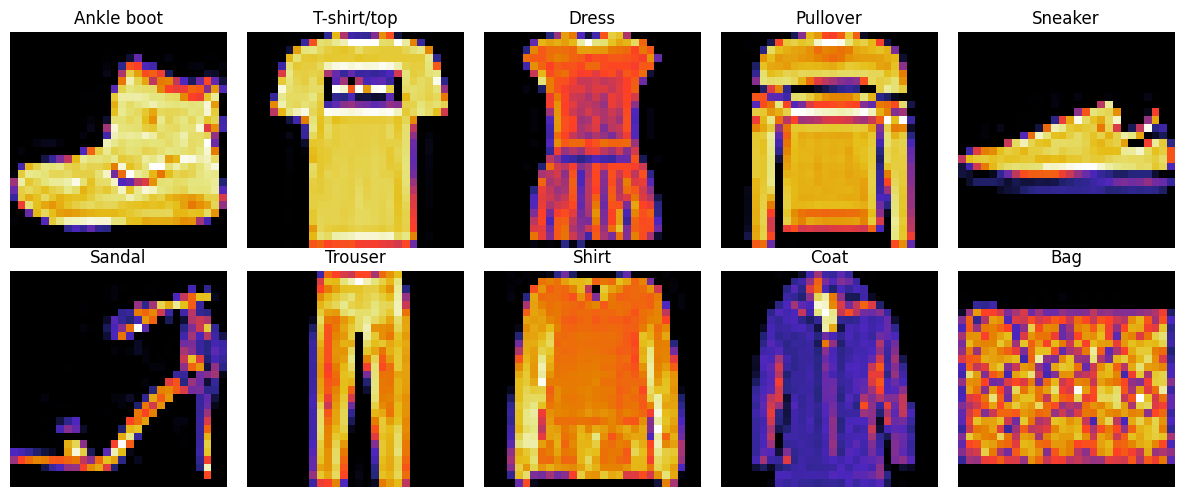

In [4]:
import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

# Load the Fashion-MNIST dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Class names for the Fashion-MNIST labels
CLASS_NAMES = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

# Function to plot one sample per class
def plot_one_sample_per_class(X, y, class_names):
    plotted_classes = set()
    plt.figure(figsize=(12, 5))
    count = 0

    for i in range(len(X)):
        label = y[i]
        if label not in plotted_classes:
            plotted_classes.add(label)
            count += 1
            plt.subplot(2, 5, count)
            # Use a grayscale colormap for clarity, but you can use others (e.g. 'BrBG', 'Blues')
            plt.imshow(X[i], cmap='CMRmap')  
            plt.title(class_names[label])
            plt.axis("off")

            if count == 10:  # We have 10 classes total
                break

    plt.tight_layout()
    plt.show()

# 1. Plot one sample per class (just a local Matplotlib plot)
plot_one_sample_per_class(X_train, y_train, CLASS_NAMES)

# 2. Initialize a Weights & Biases run
wandb.init(project="DLassignment1", name="Q1")

# Prepare two sets of 18 images each for logging
set1_images = []
set2_images = []

for i in range(18):
    set1_images.append(
        wandb.Image(
            X_train[i], 
            caption=f"{CLASS_NAMES[y_train[i]]} (idx={i})"
        )
    )

for i in range(18, 36):
    set2_images.append(
        wandb.Image(
            X_train[i], 
            caption=f"{CLASS_NAMES[y_train[i]]} (idx={i})"
        )
    )

# 3. Log these sets to W&B in a single step
wandb.log({"Set 1": set1_images, "Set 2": set2_images})

# 4. Finish the run
wandb.finish()

Q2

In [18]:
import wandb
wandb.login()

import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist


In [19]:
# Load Fashion-MNIST dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Normalize and reshape images into 784-dimensional vectors
X_train = X_train.reshape(-1, 28*28) / 255.0
X_test  = X_test.reshape(-1, 28*28) / 255.0

# One-hot encode labels
def one_hot(y, num_classes=10):
    return np.eye(num_classes)[y]

y_train_onehot = one_hot(y_train)
y_test_onehot  = one_hot(y_test)


In [20]:
class NeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.1):
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.num_layers = len(layer_sizes)
        self.weights = [np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2.0 / layer_sizes[i])
                        for i in range(self.num_layers - 1)]
        self.biases = [np.zeros((1, layer_sizes[i+1])) for i in range(self.num_layers - 1)]
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def forward(self, X):
        self.zs, self.activations = [], [X]
        A = X
        for i in range(len(self.weights) - 1):
            z = A @ self.weights[i] + self.biases[i]
            self.zs.append(z)
            A = self.relu(z)
            self.activations.append(A)
        z = A @ self.weights[-1] + self.biases[-1]
        self.zs.append(z)
        A = self.softmax(z)
        self.activations.append(A)
        return A
    
    def compute_loss(self, Y_pred, Y_true):
        return -np.sum(Y_true * np.log(Y_pred + 1e-8)) / Y_true.shape[0]
    
    def backward(self, Y_pred, Y_true):
        m = Y_true.shape[0]
        delta = (Y_pred - Y_true) / m  
        dW, db = [None] * len(self.weights), [None] * len(self.biases)
        dW[-1], db[-1] = self.activations[-2].T @ delta, np.sum(delta, axis=0, keepdims=True)
        for i in range(len(self.weights) - 2, -1, -1):
            delta = (delta @ self.weights[i+1].T) * (self.zs[i] > 0)
            dW[i], db[i] = self.activations[i].T @ delta, np.sum(delta, axis=0, keepdims=True)
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * dW[i]
            self.biases[i] -= self.learning_rate * db[i]
    
    def predict(self, X):
        return np.argmax(self.forward(X), axis=1)


In [21]:
wandb.init(project="DLassignment1", name="ques2")

layer_sizes = [784, 128, 64, 10]
nn = NeuralNetwork(layer_sizes, learning_rate=0.1)

num_epochs, batch_size = 10, 64
num_batches = X_train.shape[0] // batch_size

for epoch in range(num_epochs):
    perm = np.random.permutation(X_train.shape[0])
    X_train_shuffled, y_train_onehot_shuffled = X_train[perm], y_train_onehot[perm]
    
    epoch_loss = 0
    for i in range(num_batches):
        start, end = i * batch_size, (i + 1) * batch_size
        X_batch, y_batch = X_train_shuffled[start:end], y_train_onehot_shuffled[start:end]
        Y_pred = nn.forward(X_batch)
        epoch_loss += nn.compute_loss(Y_pred, y_batch)
        nn.backward(Y_pred, y_batch)
    
    avg_loss = epoch_loss / num_batches
    train_accuracy = np.mean(nn.predict(X_train) == y_train)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f} - Accuracy: {train_accuracy:.4f}")
    wandb.log({"epoch": epoch+1, "loss": avg_loss, "accuracy": train_accuracy})

test_accuracy = np.mean(nn.predict(X_test) == y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")
wandb.log({"test_accuracy": test_accuracy})


Epoch 1/10 - Loss: 0.5776 - Accuracy: 0.8460
Epoch 2/10 - Loss: 0.4106 - Accuracy: 0.8492
Epoch 3/10 - Loss: 0.3718 - Accuracy: 0.8765
Epoch 4/10 - Loss: 0.3467 - Accuracy: 0.8678
Epoch 5/10 - Loss: 0.3259 - Accuracy: 0.8911
Epoch 6/10 - Loss: 0.3100 - Accuracy: 0.8921
Epoch 7/10 - Loss: 0.2976 - Accuracy: 0.8927
Epoch 8/10 - Loss: 0.2877 - Accuracy: 0.8986
Epoch 9/10 - Loss: 0.2777 - Accuracy: 0.9016
Epoch 10/10 - Loss: 0.2693 - Accuracy: 0.9038
Test Accuracy: 0.8760



Test Image 25 Probability Distribution:
T-shirt/top: 0.0010
Trouser: 0.0000
Pullover: 0.8412
Dress: 0.0000
Coat: 0.1183
Sandal: 0.0000
Shirt: 0.0395
Sneaker: 0.0000
Bag: 0.0000
Ankle boot: 0.0000


Test Image 1 Probability Distribution:
T-shirt/top: 0.0000
Trouser: 0.0000
Pullover: 0.9905
Dress: 0.0000
Coat: 0.0093
Sandal: 0.0000
Shirt: 0.0002
Sneaker: 0.0000
Bag: 0.0000
Ankle boot: 0.0000


Test Image 45 Probability Distribution:
T-shirt/top: 0.0000
Trouser: 0.0000
Pullover: 0.0000
Dress: 0.0000
Coat: 0.0000
Sandal: 0.0364
Shirt: 0.0000
Sneaker: 0.9293
Bag: 0.0001
Ankle boot: 0.0342


Test Image 80 Probability Distribution:
T-shirt/top: 0.0004
Trouser: 0.9991
Pullover: 0.0001
Dress: 0.0001
Coat: 0.0002
Sandal: 0.0000
Shirt: 0.0000
Sneaker: 0.0000
Bag: 0.0000
Ankle boot: 0.0000


Test Image 980 Probability Distribution:
T-shirt/top: 0.0000
Trouser: 0.0000
Pullover: 0.0000
Dress: 0.0000
Coat: 0.0000
Sandal: 0.0000
Shirt: 0.0000
Sneaker: 0.0005
Bag: 0.0000
Ankle boot: 0.9995


Test Imag

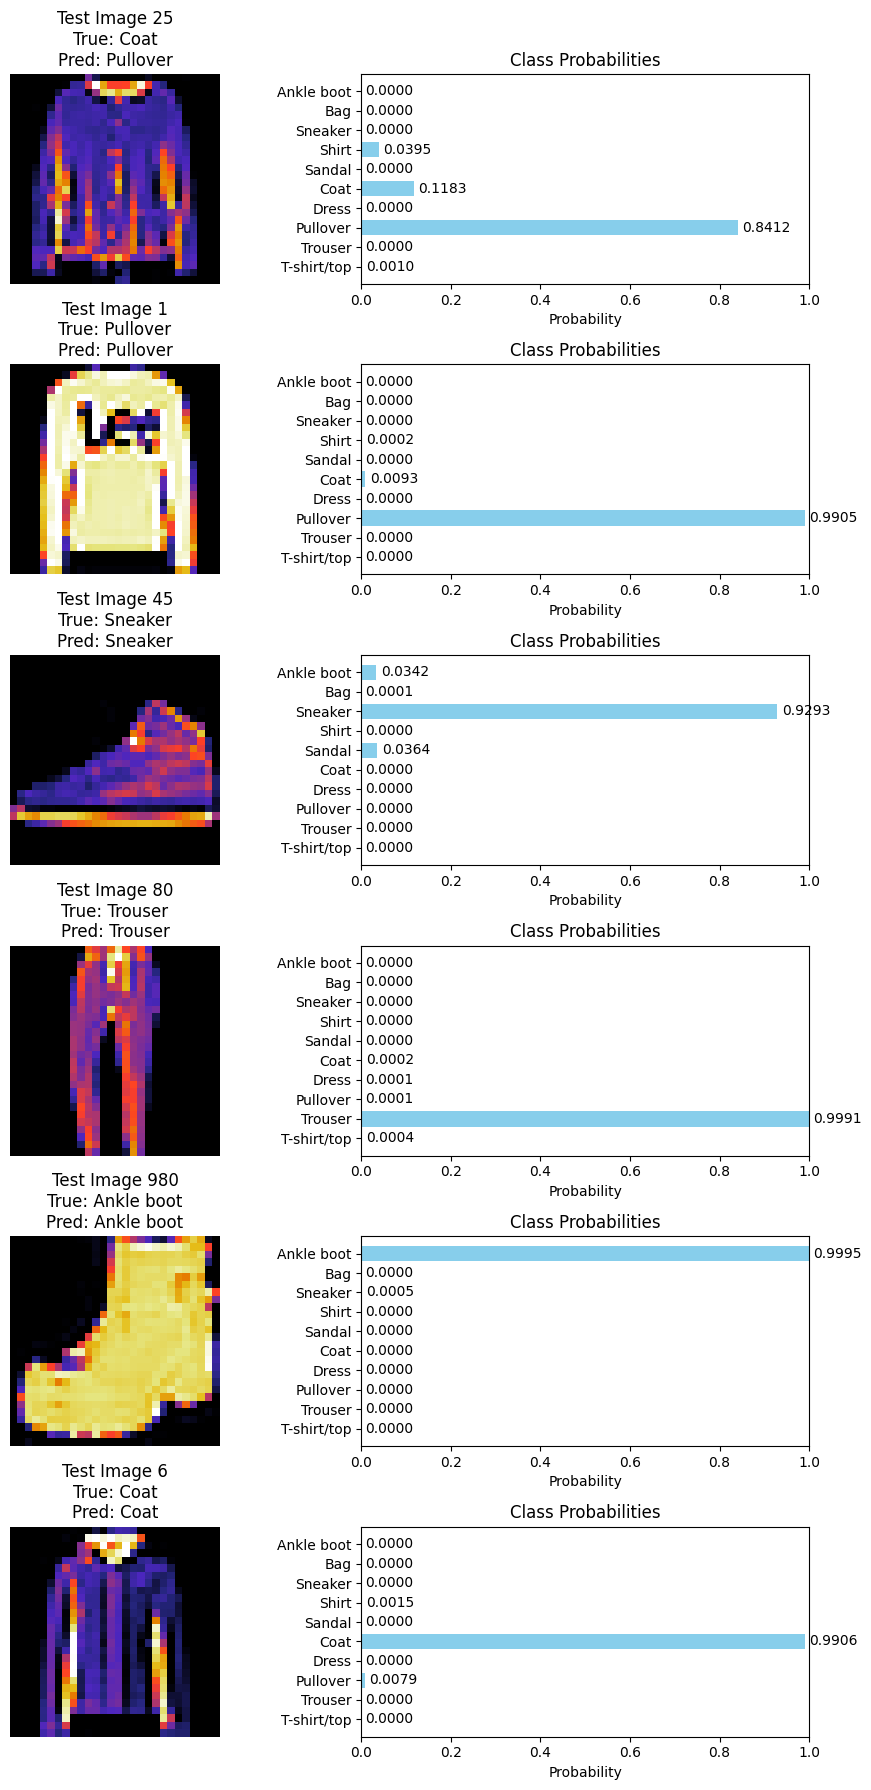

accuracy,▁▁▅▄▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▂▂▂▁▁▁
test_accuracy,▁
accuracy,0.9038
epoch,10
loss,0.26928
test_accuracy,0.876


In [23]:
import matplotlib.pyplot as plt

CLASS_NAMES = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

sample_indices = [25, 1, 45, 80, 980, 6]
table_rows = []

# Set up the figure for displaying images, probability distributions, and text output
fig, axes = plt.subplots(len(sample_indices), 2, figsize=(10, len(sample_indices) * 3))

for row, idx in enumerate(sample_indices):
    prob_dist = nn.forward(X_test[idx:idx+1])
    predicted_class = np.argmax(prob_dist)
    
    # Log probability distribution for each class
    prob_text = ""
    for i, prob in enumerate(prob_dist[0]):
        prob_text += f"{CLASS_NAMES[i]}: {prob:.4f}\n"
        table_rows.append([idx, CLASS_NAMES[i], prob])

    # Plot the test image
    axes[row, 0].imshow(X_test[idx].reshape(28, 28), cmap='CMRmap')
    axes[row, 0].set_title(f"Test Image {idx}\nTrue: {CLASS_NAMES[y_test[idx]]}\nPred: {CLASS_NAMES[predicted_class]}")
    axes[row, 0].axis('off')

    # Plot probability distribution as a bar chart
    axes[row, 1].barh(CLASS_NAMES, prob_dist[0], color='skyblue')
    axes[row, 1].set_xlim(0, 1)
    axes[row, 1].set_xlabel("Probability")
    axes[row, 1].set_title("Class Probabilities")

    # Display probability text on the right of the bar chart
    for i, prob in enumerate(prob_dist[0]):
        axes[row, 1].text(prob + 0.01, i, f"{prob:.4f}", va='center')

    # Print probability text alongside
    print(f"\nTest Image {idx} Probability Distribution:")
    print(prob_text)

plt.tight_layout()
plt.show()

# Log probability distributions to wandb
prob_table = wandb.Table(data=table_rows, columns=["Sample Index", "Class", "Probability"])
wandb.log({"sample_prob_distributions": prob_table})

wandb.finish()


# Q3

In [53]:
import wandb
wandb.login()  # Log into Weights & Biases

import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist


In [54]:
# Load Fashion-MNIST data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Flatten images (28x28 -> 784) and normalize to [0,1]
X_train = X_train.reshape(-1, 28*28) / 255.0
X_test  = X_test.reshape(-1, 28*28) / 255.0

# One-hot encoding helper function
def one_hot(y, num_classes=10):
    return np.eye(num_classes)[y]

y_train_onehot = one_hot(y_train, 10)
y_test_onehot  = one_hot(y_test, 10)


In [55]:
class NeuralNetwork:
    def __init__(self, layer_sizes):
        """
        layer_sizes: list defining the architecture, e.g. [784, 128, 64, 10]
        """
        self.layer_sizes = layer_sizes
        self.num_layers = len(layer_sizes)
        self.weights = []
        self.biases = []
        # Initialize weights and biases (using He initialization for ReLU)
        for i in range(self.num_layers - 1):
            W = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2.0 / layer_sizes[i])
            b = np.zeros((1, layer_sizes[i+1]))
            self.weights.append(W)
            self.biases.append(b)
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        return (x > 0).astype(float)
    
    def softmax(self, x):
        # Subtract max for numerical stability
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def forward(self, X):
        """Forward pass: computes activations for each layer."""
        self.zs = []               # Store linear combinations for backpropagation
        self.activations = [X]      # Input is the first activation
        
        A = X
        # Hidden layers with ReLU activation
        for i in range(len(self.weights) - 1):
            z = A.dot(self.weights[i]) + self.biases[i]
            self.zs.append(z)
            A = self.relu(z)
            self.activations.append(A)
        
        # Output layer: linear -> softmax
        z = self.activations[-1].dot(self.weights[-1]) + self.biases[-1]
        self.zs.append(z)
        A = self.softmax(z)
        self.activations.append(A)
        return A
    
    def compute_loss(self, Y_pred, Y_true):
        """Compute cross-entropy loss."""
        m = Y_true.shape[0]
        loss = -np.sum(Y_true * np.log(Y_pred + 1e-8)) / m
        return loss
    
    def backward(self, Y_pred, Y_true):
        """
        Compute gradients for weights and biases via backpropagation.
        Returns:
            dW: list of gradients for weights
            db: list of gradients for biases
        """
        m = Y_true.shape[0]
        dW = [None] * len(self.weights)
        db = [None] * len(self.biases)
        
        # Compute gradient at output layer (softmax + cross-entropy)
        delta = (Y_pred - Y_true) / m
        dW[-1] = self.activations[-2].T.dot(delta)
        db[-1] = np.sum(delta, axis=0, keepdims=True)
        
        # Propagate backwards through hidden layers
        for i in range(len(self.weights)-2, -1, -1):
            delta = delta.dot(self.weights[i+1].T) * self.relu_derivative(self.zs[i])
            dW[i] = self.activations[i].T.dot(delta)
            db[i] = np.sum(delta, axis=0, keepdims=True)
        
        return dW, db


In [56]:
# SGD Optimizer
class SGD:
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate
        
    def update(self, weights, biases, dW, db, t):
        for i in range(len(weights)):
            weights[i] -= self.learning_rate * dW[i]
            biases[i]  -= self.learning_rate * db[i]

# Momentum-Based Gradient Descent
class Momentum:
    def __init__(self, learning_rate=0.01, momentum=0.9):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.vw = None
        self.vb = None
        
    def update(self, weights, biases, dW, db, t):
        if self.vw is None:
            self.vw = [np.zeros_like(w) for w in weights]
            self.vb = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            self.vw[i] = self.momentum * self.vw[i] + self.learning_rate * dW[i]
            self.vb[i] = self.momentum * self.vb[i] + self.learning_rate * db[i]
            weights[i] -= self.vw[i]
            biases[i]  -= self.vb[i]

# Nesterov Accelerated Gradient Descent
class Nesterov:
    def __init__(self, learning_rate=0.01, momentum=0.9):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.vw = None
        self.vb = None
        
    def update(self, weights, biases, dW, db, t):
        if self.vw is None:
            self.vw = [np.zeros_like(w) for w in weights]
            self.vb = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            # Save previous velocity
            v_prev_w = self.vw[i].copy()
            v_prev_b = self.vb[i].copy()
            # Update velocity
            self.vw[i] = self.momentum * self.vw[i] + self.learning_rate * dW[i]
            self.vb[i] = self.momentum * self.vb[i] + self.learning_rate * db[i]
            # Nesterov update (lookahead)
            weights[i] -= -self.momentum * v_prev_w + (1 + self.momentum) * self.vw[i]
            biases[i]  -= -self.momentum * v_prev_b + (1 + self.momentum) * self.vb[i]

# RMSProp Optimizer
# RMSProp Optimizer
class RMSProp:
    def __init__(self, learning_rate=0.001, decay_rate=0.9, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self.epsilon = epsilon
        self.Sw = None
        self.Sb = None
        
    def update(self, weights, biases, dW, db, t):
        if self.Sw is None:
            self.Sw = [np.zeros_like(w) for w in weights]
            self.Sb = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            self.Sw[i] = self.decay_rate * self.Sw[i] + (1 - self.decay_rate) * (dW[i] ** 2)
            self.Sb[i] = self.decay_rate * self.Sb[i] + (1 - self.decay_rate) * (db[i] ** 2)
            weights[i] -= self.learning_rate * dW[i] / (np.sqrt(self.Sw[i]) + self.epsilon)
            biases[i]  -= self.learning_rate * db[i] / (np.sqrt(self.Sb[i]) + self.epsilon)

# Adam Optimizer
class Adam:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mw = None
        self.vw = None
        self.mb = None
        self.vb = None
        
    def update(self, weights, biases, dW, db, t):
        if self.mw is None:
            self.mw = [np.zeros_like(w) for w in weights]
            self.vw = [np.zeros_like(w) for w in weights]
            self.mb = [np.zeros_like(b) for b in biases]
            self.vb = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            self.mw[i] = self.beta1 * self.mw[i] + (1 - self.beta1) * dW[i]
            self.vw[i] = self.beta2 * self.vw[i] + (1 - self.beta2) * (dW[i] ** 2)
            self.mb[i] = self.beta1 * self.mb[i] + (1 - self.beta1) * db[i]
            self.vb[i] = self.beta2 * self.vb[i] + (1 - self.beta2) * (db[i] ** 2)
            
            m_hat_w = self.mw[i] / (1 - self.beta1 ** t)
            v_hat_w = self.vw[i] / (1 - self.beta2 ** t)
            m_hat_b = self.mb[i] / (1 - self.beta1 ** t)
            v_hat_b = self.vb[i] / (1 - self.beta2 ** t)
            
            weights[i] -= self.learning_rate * m_hat_w / (np.sqrt(v_hat_w) + self.epsilon)
            biases[i]  -= self.learning_rate * m_hat_b / (np.sqrt(v_hat_b) + self.epsilon)

# Nadam Optimizer (Adam with Nesterov momentum) - Corrected Bias Update
class Nadam:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mw = None
        self.vw = None
        self.mb = None
        self.vb = None
        
    def update(self, weights, biases, dW, db, t):
        if self.mw is None:
            self.mw = [np.zeros_like(w) for w in weights]
            self.vw = [np.zeros_like(w) for w in weights]
            self.mb = [np.zeros_like(b) for b in biases]
            self.vb = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            self.mw[i] = self.beta1 * self.mw[i] + (1 - self.beta1) * dW[i]
            self.vw[i] = self.beta2 * self.vw[i] + (1 - self.beta2) * (dW[i] ** 2)
            self.mb[i] = self.beta1 * self.mb[i] + (1 - self.beta1) * db[i]
            self.vb[i] = self.beta2 * self.vb[i] + (1 - self.beta2) * (db[i] ** 2)
            
            m_hat = self.mw[i] / (1 - self.beta1 ** t)
            v_hat = self.vw[i] / (1 - self.beta2 ** t)
            m_hat_b = self.mb[i] / (1 - self.beta1 ** t)
            v_hat_b = self.vb[i] / (1 - self.beta2 ** t)
            
            weights[i] -= self.learning_rate * (self.beta1 * m_hat + (1 - self.beta1) * dW[i] / (1 - self.beta1 ** t)) / (np.sqrt(v_hat) + self.epsilon)
            # Corrected: use v_hat_b for bias update
            biases[i]  -= self.learning_rate * (self.beta1 * m_hat_b + (1 - self.beta1) * db[i] / (1 - self.beta1 ** t)) / (np.sqrt(v_hat_b) + self.epsilon)


In [57]:
# Define a dictionary mapping optimizer names to functions that return a new optimizer instance.
optimizers_dict = {
    "SGD": lambda: SGD(learning_rate=0.01),
    "Momentum": lambda: Momentum(learning_rate=0.01, momentum=0.9),
    "Nesterov": lambda: Nesterov(learning_rate=0.01, momentum=0.9),
    "RMSProp": lambda: RMSProp(learning_rate=0.001, decay_rate=0.9),
    "Adam": lambda: Adam(learning_rate=0.001, beta1=0.9, beta2=0.999),
    "Nadam": lambda: Nadam(learning_rate=0.001, beta1=0.9, beta2=0.999)
}

# Common training parameters
num_epochs = 10
batch_size = 64
num_batches = X_train.shape[0] // batch_size
layer_sizes = [784, 128, 64, 10]

# To store summary results for each optimizer.
results = []

# Loop over each optimizer and run a separate training experiment.
for opt_name, opt_fn in optimizers_dict.items():
    # Initialize a new wandb run for each optimizer.
    run = wandb.init(project="DLassignment1", 
                     name=f"ques3_{opt_name}", 
                     reinit=True, 
                     config={
                         "optimizer": opt_name,
                         "num_epochs": num_epochs,
                         "batch_size": batch_size,
                         "layer_sizes": layer_sizes
                     })
    
    # Initialize a new neural network and optimizer instance.
    nn = NeuralNetwork(layer_sizes)
    optimizer = opt_fn()
    
    global_step = 1
    epoch_losses = []
    
    print(f"\nStarting training with optimizer: {opt_name}")
    for epoch in range(num_epochs):
        # Shuffle training data at the start of each epoch.
        perm = np.random.permutation(X_train.shape[0])
        X_train_shuffled = X_train[perm]
        y_train_onehot_shuffled = y_train_onehot[perm]
        
        epoch_loss = 0
        for i in range(num_batches):
            start = i * batch_size
            end = start + batch_size
            X_batch = X_train_shuffled[start:end]
            y_batch = y_train_onehot_shuffled[start:end]
            
            # Forward pass.
            Y_pred = nn.forward(X_batch)
            loss = nn.compute_loss(Y_pred, y_batch)
            epoch_loss += loss
            
            # Backward pass: compute gradients.
            dW, db = nn.backward(Y_pred, y_batch)
            
            # Update parameters using the chosen optimizer.
            optimizer.update(nn.weights, nn.biases, dW, db, global_step)
            global_step += 1
        
        avg_loss = epoch_loss / num_batches
        epoch_losses.append(avg_loss)
        
        # Evaluate training accuracy on the entire training set.
        train_predictions = np.argmax(nn.forward(X_train), axis=1)
        train_accuracy = np.mean(train_predictions == y_train)
        
        print(f"{opt_name} | Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f} - Train Accuracy: {train_accuracy:.4f}")
        wandb.log({"epoch": epoch+1, "loss": avg_loss, "train_accuracy": train_accuracy})
    
    # Evaluate on the test set.
    test_predictions = np.argmax(nn.forward(X_test), axis=1)
    test_accuracy = np.mean(test_predictions == y_test)
    print(f"{opt_name} | Test Accuracy: {test_accuracy:.4f}")
    wandb.log({"test_accuracy": test_accuracy})
    
    # Save final results for this optimizer.
    results.append({
        "Optimizer": opt_name,
        "Final Train Accuracy": train_accuracy,
        "Test Accuracy": test_accuracy,
        "Final Loss": avg_loss
    })
    
    run.finish()



Starting training with optimizer: SGD
SGD | Epoch 1/10 - Loss: 0.8474 - Train Accuracy: 0.7936
SGD | Epoch 2/10 - Loss: 0.5446 - Train Accuracy: 0.8250
SGD | Epoch 3/10 - Loss: 0.4900 - Train Accuracy: 0.8385
SGD | Epoch 4/10 - Loss: 0.4620 - Train Accuracy: 0.8376
SGD | Epoch 5/10 - Loss: 0.4424 - Train Accuracy: 0.8404
SGD | Epoch 6/10 - Loss: 0.4275 - Train Accuracy: 0.8531
SGD | Epoch 7/10 - Loss: 0.4162 - Train Accuracy: 0.8538
SGD | Epoch 8/10 - Loss: 0.4052 - Train Accuracy: 0.8640
SGD | Epoch 9/10 - Loss: 0.3954 - Train Accuracy: 0.8618
SGD | Epoch 10/10 - Loss: 0.3869 - Train Accuracy: 0.8667
SGD | Test Accuracy: 0.8504


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▃▂▂▂▁▁▁▁
test_accuracy,▁
train_accuracy,▁▄▅▅▅▇▇███
epoch,10
loss,0.38691
test_accuracy,0.8504
train_accuracy,0.86672



Starting training with optimizer: Momentum
Momentum | Epoch 1/10 - Loss: 0.5595 - Train Accuracy: 0.8504
Momentum | Epoch 2/10 - Loss: 0.4008 - Train Accuracy: 0.8655
Momentum | Epoch 3/10 - Loss: 0.3610 - Train Accuracy: 0.8841
Momentum | Epoch 4/10 - Loss: 0.3353 - Train Accuracy: 0.8789
Momentum | Epoch 5/10 - Loss: 0.3178 - Train Accuracy: 0.8870
Momentum | Epoch 6/10 - Loss: 0.3060 - Train Accuracy: 0.8957
Momentum | Epoch 7/10 - Loss: 0.2929 - Train Accuracy: 0.8954
Momentum | Epoch 8/10 - Loss: 0.2824 - Train Accuracy: 0.8966
Momentum | Epoch 9/10 - Loss: 0.2754 - Train Accuracy: 0.9050
Momentum | Epoch 10/10 - Loss: 0.2671 - Train Accuracy: 0.9046
Momentum | Test Accuracy: 0.8765


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▂▂▂▁▁▁
test_accuracy,▁
train_accuracy,▁▃▅▅▆▇▇▇██
epoch,10
loss,0.26707
test_accuracy,0.8765
train_accuracy,0.90462



Starting training with optimizer: Nesterov
Nesterov | Epoch 1/10 - Loss: 0.5452 - Train Accuracy: 0.8488
Nesterov | Epoch 2/10 - Loss: 0.3974 - Train Accuracy: 0.8725
Nesterov | Epoch 3/10 - Loss: 0.3600 - Train Accuracy: 0.8769
Nesterov | Epoch 4/10 - Loss: 0.3355 - Train Accuracy: 0.8877
Nesterov | Epoch 5/10 - Loss: 0.3163 - Train Accuracy: 0.8948
Nesterov | Epoch 6/10 - Loss: 0.3004 - Train Accuracy: 0.8953
Nesterov | Epoch 7/10 - Loss: 0.2908 - Train Accuracy: 0.9020
Nesterov | Epoch 8/10 - Loss: 0.2806 - Train Accuracy: 0.9011
Nesterov | Epoch 9/10 - Loss: 0.2701 - Train Accuracy: 0.9021
Nesterov | Epoch 10/10 - Loss: 0.2626 - Train Accuracy: 0.9112
Nesterov | Test Accuracy: 0.8802


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▂▂▂▁▁▁
test_accuracy,▁
train_accuracy,▁▄▄▅▆▆▇▇▇█
epoch,10
loss,0.26265
test_accuracy,0.8802
train_accuracy,0.91115



Starting training with optimizer: RMSProp
RMSProp | Epoch 1/10 - Loss: 0.5266 - Train Accuracy: 0.8651
RMSProp | Epoch 2/10 - Loss: 0.3822 - Train Accuracy: 0.8746
RMSProp | Epoch 3/10 - Loss: 0.3472 - Train Accuracy: 0.8851
RMSProp | Epoch 4/10 - Loss: 0.3210 - Train Accuracy: 0.8841
RMSProp | Epoch 5/10 - Loss: 0.3062 - Train Accuracy: 0.8887
RMSProp | Epoch 6/10 - Loss: 0.2942 - Train Accuracy: 0.8976
RMSProp | Epoch 7/10 - Loss: 0.2839 - Train Accuracy: 0.9073
RMSProp | Epoch 8/10 - Loss: 0.2761 - Train Accuracy: 0.9058
RMSProp | Epoch 9/10 - Loss: 0.2660 - Train Accuracy: 0.9030
RMSProp | Epoch 10/10 - Loss: 0.2618 - Train Accuracy: 0.9022
RMSProp | Test Accuracy: 0.8681


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▂▂▂▁▁▁
test_accuracy,▁
train_accuracy,▁▃▄▄▅▆██▇▇
epoch,10
loss,0.26179
test_accuracy,0.8681
train_accuracy,0.90225



Starting training with optimizer: Adam
Adam | Epoch 1/10 - Loss: 0.5090 - Train Accuracy: 0.8598
Adam | Epoch 2/10 - Loss: 0.3731 - Train Accuracy: 0.8804
Adam | Epoch 3/10 - Loss: 0.3373 - Train Accuracy: 0.8792
Adam | Epoch 4/10 - Loss: 0.3123 - Train Accuracy: 0.8971
Adam | Epoch 5/10 - Loss: 0.2938 - Train Accuracy: 0.8869
Adam | Epoch 6/10 - Loss: 0.2818 - Train Accuracy: 0.8988
Adam | Epoch 7/10 - Loss: 0.2684 - Train Accuracy: 0.8975
Adam | Epoch 8/10 - Loss: 0.2575 - Train Accuracy: 0.9119
Adam | Epoch 9/10 - Loss: 0.2497 - Train Accuracy: 0.9147
Adam | Epoch 10/10 - Loss: 0.2406 - Train Accuracy: 0.9172
Adam | Test Accuracy: 0.8845


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▄▃▂▂▂▁▁▁
test_accuracy,▁
train_accuracy,▁▄▃▆▄▆▆▇██
epoch,10
loss,0.24059
test_accuracy,0.8845
train_accuracy,0.91717



Starting training with optimizer: Nadam
Nadam | Epoch 1/10 - Loss: 0.4902 - Train Accuracy: 0.8590
Nadam | Epoch 2/10 - Loss: 0.3632 - Train Accuracy: 0.8787
Nadam | Epoch 3/10 - Loss: 0.3287 - Train Accuracy: 0.8881
Nadam | Epoch 4/10 - Loss: 0.3054 - Train Accuracy: 0.8900
Nadam | Epoch 5/10 - Loss: 0.2878 - Train Accuracy: 0.9028
Nadam | Epoch 6/10 - Loss: 0.2740 - Train Accuracy: 0.9090
Nadam | Epoch 7/10 - Loss: 0.2621 - Train Accuracy: 0.9088
Nadam | Epoch 8/10 - Loss: 0.2510 - Train Accuracy: 0.9082
Nadam | Epoch 9/10 - Loss: 0.2408 - Train Accuracy: 0.9139
Nadam | Epoch 10/10 - Loss: 0.2331 - Train Accuracy: 0.9167
Nadam | Test Accuracy: 0.8823


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
test_accuracy,▁
train_accuracy,▁▃▅▅▆▇▇▇██
epoch,10
loss,0.23313
test_accuracy,0.8823
train_accuracy,0.91675


In [58]:
# Create a wandb Table with the summary results.
summary_table = wandb.Table(columns=["Optimizer", "Final Train Accuracy", "Test Accuracy", "Final Loss"])
for res in results:
    summary_table.add_data(res["Optimizer"], res["Final Train Accuracy"], res["Test Accuracy"], res["Final Loss"])

# Initialize a new run to log the summary comparison.
summary_run = wandb.init(project="DLassignment1", name="ques_3_summary", reinit=True)
wandb.log({"Optimizer Comparison": summary_table})
summary_run.finish()

# Optionally, print the summary table.
print("\nSummary of Optimizer Performance:")
for res in results:
    print(f"{res['Optimizer']:10s} | Train Acc: {res['Final Train Accuracy']:.4f} | Test Acc: {res['Test Accuracy']:.4f} | Final Loss: {res['Final Loss']:.4f}")



Summary of Optimizer Performance:
SGD        | Train Acc: 0.8667 | Test Acc: 0.8504 | Final Loss: 0.3869
Momentum   | Train Acc: 0.9046 | Test Acc: 0.8765 | Final Loss: 0.2671
Nesterov   | Train Acc: 0.9112 | Test Acc: 0.8802 | Final Loss: 0.2626
RMSProp    | Train Acc: 0.9022 | Test Acc: 0.8681 | Final Loss: 0.2618
Adam       | Train Acc: 0.9172 | Test Acc: 0.8845 | Final Loss: 0.2406
Nadam      | Train Acc: 0.9167 | Test Acc: 0.8823 | Final Loss: 0.2331


# Q4:

In [59]:
import wandb
wandb.login()

import numpy as np
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt

# 1. Load Fashion-MNIST
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

# 2. Split off 10% of the training set as validation data
val_split = int(0.1 * X_train_full.shape[0])
X_val = X_train_full[:val_split]
y_val = y_train_full[:val_split]
X_train = X_train_full[val_split:]
y_train = y_train_full[val_split:]

# 3. Flatten and normalize images (28x28 -> 784) in [0,1]
X_train = X_train.reshape(-1, 28*28) / 255.0
X_val   = X_val.reshape(-1, 28*28)   / 255.0
X_test  = X_test.reshape(-1, 28*28)  / 255.0

# 4. One-hot encode labels
def one_hot(y, num_classes=10):
    return np.eye(num_classes)[y]

y_train_oh = one_hot(y_train)
y_val_oh   = one_hot(y_val)
y_test_oh  = one_hot(y_test)


In [60]:
def xavier_init(fan_in, fan_out):
    """Xavier/Glorot initialization."""
    limit = np.sqrt(6 / (fan_in + fan_out))
    return np.random.uniform(-limit, limit, (fan_in, fan_out))

class SimpleMLP:
    def __init__(self, input_dim, num_hidden_layers, hidden_size, output_dim,
                 weight_init='random', activation='relu', weight_decay=0.0):
        """
        input_dim: 784 for Fashion-MNIST
        num_hidden_layers: 3,4,5
        hidden_size: 32,64,128
        output_dim: 10
        weight_init: 'random' or 'xavier'
        activation: 'relu', 'sigmoid', 'tanh'
        weight_decay: L2 regularization factor
        """
        self.num_hidden_layers = num_hidden_layers
        self.hidden_size = hidden_size
        self.activation_name = activation
        self.weight_decay = weight_decay
        
        # Activation functions
        if activation == 'relu':
            self.activation = lambda x: np.maximum(0, x)
            self.activation_deriv = lambda x: (x > 0).astype(float)
        elif activation == 'sigmoid':
            self.activation = lambda x: 1.0 / (1.0 + np.exp(-x))
            self.activation_deriv = lambda x: self.activation(x) * (1 - self.activation(x))
        elif activation == 'tanh':
            self.activation = lambda x: np.tanh(x)
            self.activation_deriv = lambda x: 1 - np.tanh(x)**2
        else:
            raise ValueError("Unsupported activation")

        # Build architecture
        layer_dims = [input_dim] + [hidden_size]*num_hidden_layers + [output_dim]
        self.weights = []
        self.biases  = []
        
        for i in range(len(layer_dims) - 1):
            fan_in  = layer_dims[i]
            fan_out = layer_dims[i+1]
            
            if weight_init == 'xavier':
                W = xavier_init(fan_in, fan_out)
            else:
                # random normal initialization (He or simple normal)
                W = np.random.randn(fan_in, fan_out) * 0.01
            
            b = np.zeros((1, fan_out))
            self.weights.append(W)
            self.biases.append(b)
    
    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)
    
    def forward(self, X):
        """
        Forward pass: returns the output of the network (softmax probabilities).
        Also stores intermediate results for backprop.
        """
        self.zs = []          # linear combinations
        self.activations = [X]  # store all activations
        A = X
        
        for i in range(len(self.weights) - 1):
            z = A.dot(self.weights[i]) + self.biases[i]
            self.zs.append(z)
            A = self.activation(z)
            self.activations.append(A)
        
        # Output layer
        z = A.dot(self.weights[-1]) + self.biases[-1]
        self.zs.append(z)
        out = self.softmax(z)
        self.activations.append(out)
        return out
    
    def compute_loss(self, y_pred, y_true):
        """
        Cross-entropy + L2 regularization (if weight_decay > 0).
        """
        m = y_true.shape[0]
        log_likelihood = -np.sum(y_true * np.log(y_pred + 1e-8)) / m
        
        # L2 regularization
        l2_reg = 0
        if self.weight_decay > 0:
            for W in self.weights:
                l2_reg += np.sum(W**2)
            l2_reg = (self.weight_decay / (2*m)) * l2_reg
        
        return log_likelihood + l2_reg
    
    def backward(self, y_pred, y_true, learning_rate):
        """
        Backpropagation + gradient descent update.
        """
        m = y_true.shape[0]
        dW = [None]*len(self.weights)
        db = [None]*len(self.biases)
        
        # Output layer gradient
        delta = (y_pred - y_true) / m  # derivative for softmax cross-entropy
        dW[-1] = self.activations[-2].T.dot(delta)
        db[-1] = np.sum(delta, axis=0, keepdims=True)
        
        # Hidden layers
        for i in range(len(self.weights)-2, -1, -1):
            delta = delta.dot(self.weights[i+1].T) * self.activation_deriv(self.zs[i])
            dW[i] = self.activations[i].T.dot(delta)
            db[i] = np.sum(delta, axis=0, keepdims=True)
        
        # L2 penalty
        if self.weight_decay > 0:
            for i in range(len(self.weights)):
                dW[i] += (self.weight_decay * self.weights[i]) / m
        
        # Gradient descent update
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * dW[i]
            self.biases[i]  -= learning_rate * db[i]


In [61]:
def train_model_sweep(config=None):
    with wandb.init(config=config):
        config = wandb.config
        
        # Build the model
        mlp = SimpleMLP(
            input_dim=784,
            num_hidden_layers=config.num_hidden_layers,
            hidden_size=config.hidden_layer_size,
            output_dim=10,
            weight_init=config.weight_init,
            activation=config.activation_function,
            weight_decay=config.weight_decay
        )
        
        # Training loop
        for epoch in range(config.epochs):
            # Mini-batch training
            num_samples = X_train.shape[0]
            indices = np.random.permutation(num_samples)
            X_train_shuffled = X_train[indices]
            y_train_shuffled = y_train_oh[indices]
            
            for start_idx in range(0, num_samples, config.batch_size):
                end_idx = start_idx + config.batch_size
                X_batch = X_train_shuffled[start_idx:end_idx]
                y_batch = y_train_shuffled[start_idx:end_idx]
                
                # Forward + Backprop
                y_pred = mlp.forward(X_batch)
                mlp.backward(y_pred, y_batch, config.learning_rate)
            
            # Evaluate on validation set
            val_pred = mlp.forward(X_val)
            val_loss = mlp.compute_loss(val_pred, y_val_oh)
            val_acc  = np.mean(np.argmax(val_pred, axis=1) == y_val)
            
            # Log metrics
            wandb.log({
                "epoch": epoch+1,
                "val_loss": val_loss,
                "val_accuracy": val_acc
            })
        
        # Final test accuracy
        test_pred = mlp.forward(X_test)
        test_loss = mlp.compute_loss(test_pred, y_test_oh)
        test_acc  = np.mean(np.argmax(test_pred, axis=1) == y_test)
        
        wandb.log({
            "test_loss": test_loss,
            "test_accuracy": test_acc
        })
        
        # Optionally rename the run to reflect hyperparameters
        run_name = f"hl_{config.num_hidden_layers}_bs_{config.batch_size}_act_{config.activation_function}"
        wandb.run.name = run_name
        print(f"Run {run_name} finished with val_acc={val_acc:.4f}, test_acc={test_acc:.4f}")


In [62]:
sweep_config = {
    'method': 'random',  # or 'grid', 'bayes'
    'metric': {
      'name': 'val_loss',  # We'll optimize validation loss
      'goal': 'minimize' 
    },
    'parameters': {
        'epochs': {
            'values': [5, 10]
        },
        'num_hidden_layers': {
            'values': [3, 4, 5]
        },
        'hidden_layer_size': {
            'values': [32, 64, 128]
        },
        'weight_decay': {
            'values': [0, 0.0005, 0.5]
        },
        'learning_rate': {
            'values': [1e-3, 1e-4]
        },
        'optimizer': {
            # We haven't implemented all separate optimizers here, 
            # but you can add logic to `train_model_sweep` if you want to
            # do Momentum, Nesterov, etc. For now let's keep it simple:
            'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']
        },
        'batch_size': {
            'values': [16, 32, 64]
        },
        'weight_init': {
            'values': ['random', 'xavier']
        },
        'activation_function': {
            'values': ['sigmoid', 'tanh', 'relu']
        }
    }
}


In [63]:
# Create the sweep
sweep_id = wandb.sweep(sweep_config, project="DLassignment1")

# Launch the sweep agent
# count=10 means run 10 different random combos; increase as needed
wandb.agent(sweep_id, train_model_sweep, count=30)


Create sweep with ID: scuuqo19
Sweep URL: https://wandb.ai/snehalma23m020-iit-madras/DLassignment1/sweeps/scuuqo19


wandb: Agent Starting Run: 4fmxyqpk with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_tanh finished with val_acc=0.7963, test_acc=0.7831


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,0.7831
test_loss,0.65588
val_accuracy,0.79633
val_loss,0.63734


wandb: Agent Starting Run: 52897072 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_tanh finished with val_acc=0.8052, test_acc=0.7919


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,5
test_accuracy,0.7919
test_loss,0.62952
val_accuracy,0.80517
val_loss,0.61857


wandb: Agent Starting Run: 9srjbjaq with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_3_bs_16_act_sigmoid finished with val_acc=0.0983, test_acc=0.1000


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁█▃▃▃
val_loss,█▁▂▆▁
epoch,5
test_accuracy,0.1
test_loss,2.30264
val_accuracy,0.09833
val_loss,2.30281


wandb: Agent Starting Run: hah9r5j5 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_5_bs_16_act_relu finished with val_acc=0.7823, test_acc=0.7737


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▆▆▇▇███
val_loss,█▄▃▃▂▂▂▁▁▁
epoch,10
test_accuracy,0.7737
test_loss,0.68541
val_accuracy,0.78233
val_loss,0.66882


wandb: Agent Starting Run: zk5aekd1 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_16_act_sigmoid finished with val_acc=0.0932, test_acc=0.0995


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,██▅▅▅▆▁▃▂▁
val_loss,█▃▂▁▁▁▁▁▁▁
epoch,10
test_accuracy,0.0995
test_loss,2.30243
val_accuracy,0.09317
val_loss,2.30253


wandb: Agent Starting Run: eeks6jdr with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Run hl_3_bs_32_act_relu finished with val_acc=0.0933, test_acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▄▆▇███▆▆▅
epoch,10
test_accuracy,0.1
test_loss,2.30267
val_accuracy,0.09333
val_loss,2.30284


wandb: Agent Starting Run: f2tpn45o with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_relu finished with val_acc=0.7448, test_acc=0.7268


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▇▇█
val_loss,█▄▂▂▁
epoch,5
test_accuracy,0.7268
test_loss,0.78149
val_accuracy,0.74483
val_loss,0.75807


wandb: Agent Starting Run: x5ol1uzd with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_4_bs_32_act_tanh finished with val_acc=0.0933, test_acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▂▃▃▄▅▆▇▇█
epoch,10
test_accuracy,0.1
test_loss,2.30259
val_accuracy,0.09333
val_loss,2.30261


wandb: Agent Starting Run: 38f1h335 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu finished with val_acc=0.3440, test_acc=0.3327


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▃▄▅▅▆▆▇█
val_loss,█▇▇▆▅▅▄▃▂▁
epoch,10
test_accuracy,0.3327
test_loss,1.97493
val_accuracy,0.344
val_loss,1.96895


wandb: Agent Starting Run: u20zy9sm with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_16_act_tanh finished with val_acc=0.8317, test_acc=0.8158


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆██
val_loss,█▄▃▂▁
epoch,5
test_accuracy,0.8158
test_loss,0.5177
val_accuracy,0.83167
val_loss,0.48613


wandb: Agent Starting Run: yr36uotm with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_tanh finished with val_acc=0.7313, test_acc=0.7039


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▆▅▄▃▂▂▂▁▁
epoch,10
test_accuracy,0.7039
test_loss,0.91263
val_accuracy,0.73133
val_loss,0.88916


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: f3ct3lyq with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Run hl_5_bs_32_act_sigmoid finished with val_acc=0.0973, test_acc=0.1000


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▃▅█▂▁
val_loss,█▁▄█▆
epoch,5
test_accuracy,0.1
test_loss,2.30279
val_accuracy,0.09733
val_loss,2.30297


wandb: Agent Starting Run: 9ntzt9nu with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_4_bs_64_act_sigmoid finished with val_acc=0.0933, test_acc=0.1000


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,█▆▁▆▁
val_loss,▇▁█▇▃
epoch,5
test_accuracy,0.1
test_loss,2.30261
val_accuracy,0.09333
val_loss,2.30272


wandb: Agent Starting Run: pewaz05g with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_5_bs_64_act_relu finished with val_acc=0.0933, test_acc=0.1000


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▁▁▁
val_loss,▁▃▅▆█
epoch,5
test_accuracy,0.1
test_loss,2.30259
val_accuracy,0.09333
val_loss,2.30263


wandb: Agent Starting Run: 8agjkhkf with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_3_bs_64_act_sigmoid finished with val_acc=0.0933, test_acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▃▂▂▂▁▁
epoch,10
test_accuracy,0.1
test_loss,2.30267
val_accuracy,0.09333
val_loss,2.30292


wandb: Agent Starting Run: sijk8dts with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Run hl_5_bs_64_act_relu finished with val_acc=0.0933, test_acc=0.1000


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▁▁▁
val_loss,▁▃▅▆█
epoch,5
test_accuracy,0.1
test_loss,2.303
val_accuracy,0.09333
val_loss,2.30328


wandb: Agent Starting Run: lqfm5z9q with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_4_bs_16_act_sigmoid finished with val_acc=0.0990, test_acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▇▁▂▂▃▇▇▃█▃
val_loss,█▆▅▄▃▂▂▂▁▁
epoch,10
test_accuracy,0.1
test_loss,2.30315
val_accuracy,0.099
val_loss,2.30364


wandb: Agent Starting Run: sm4pmwfl with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Run hl_3_bs_32_act_relu finished with val_acc=0.0933, test_acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▃▆███▇▆▆▅
epoch,10
test_accuracy,0.1
test_loss,2.30267
val_accuracy,0.09333
val_loss,2.30284


wandb: Agent Starting Run: 7j6e04kz with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_sigmoid finished with val_acc=0.0933, test_acc=0.0967


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁██▇▄
val_loss,█▄▂▁▁
epoch,5
test_accuracy,0.0967
test_loss,2.32246
val_accuracy,0.09333
val_loss,2.33524


wandb: Agent Starting Run: b9n7crh0 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_16_act_sigmoid finished with val_acc=0.0983, test_acc=0.1000


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▇▁▇█▇
val_loss,█▃▃▂▁
epoch,5
test_accuracy,0.1
test_loss,2.302
val_accuracy,0.09833
val_loss,2.30216


wandb: Agent Starting Run: 8y6i3is5 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_3_bs_32_act_tanh finished with val_acc=0.0933, test_acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,█▁▁▁▁▁▁▁▁▁
val_loss,▁▂▃▄▄▅▆▇▇█
epoch,10
test_accuracy,0.1
test_loss,2.30258
val_accuracy,0.09333
val_loss,2.3026


wandb: Agent Starting Run: 5ir8wpep with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_sigmoid finished with val_acc=0.2515, test_acc=0.2544


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▂▁▃▅▅▆▆▆▇█
val_loss,█▃▂▂▂▂▂▁▁▁
epoch,10
test_accuracy,0.2544
test_loss,2.30277
val_accuracy,0.2515
val_loss,2.3067


wandb: Agent Starting Run: 38k16gsc with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_16_act_tanh finished with val_acc=0.8555, test_acc=0.8440


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▆▇▇▇███
val_loss,█▅▃▃▂▂▁▁▁▁
epoch,10
test_accuracy,0.844
test_loss,0.44309
val_accuracy,0.8555
val_loss,0.40435


wandb: Agent Starting Run: 9ygibyu8 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_16_act_sigmoid finished with val_acc=0.0933, test_acc=0.1000


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,█▅▅█▁
val_loss,▆██▁▄
epoch,5
test_accuracy,0.1
test_loss,2.30249
val_accuracy,0.09333
val_loss,2.30266


wandb: Agent Starting Run: xih9iiku with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Run hl_4_bs_16_act_sigmoid finished with val_acc=0.1072, test_acc=0.1000


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▃▄█
val_loss,█▁▃▁▁
epoch,5
test_accuracy,0.1
test_loss,2.30265
val_accuracy,0.10717
val_loss,2.3027


wandb: Agent Starting Run: tjfkjfrs with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Run hl_5_bs_16_act_tanh finished with val_acc=0.0933, test_acc=0.1000


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▁▁▁
val_loss,▁▃▅▆█
epoch,5
test_accuracy,0.1
test_loss,2.30265
val_accuracy,0.09333
val_loss,2.30272


wandb: Agent Starting Run: pxgko4er with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_4_bs_16_act_relu finished with val_acc=0.0933, test_acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▂▃▄▄▅▆▇▇█
epoch,10
test_accuracy,0.1
test_loss,2.30259
val_accuracy,0.09333
val_loss,2.30262


wandb: Agent Starting Run: kdwzljp4 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_3_bs_16_act_tanh finished with val_acc=0.0933, test_acc=0.1000


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▁▁▁
val_loss,▁▅▇██
epoch,5
test_accuracy,0.1
test_loss,2.30253
val_accuracy,0.09333
val_loss,2.30265


wandb: Agent Starting Run: amnhfqcl with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_5_bs_64_act_sigmoid finished with val_acc=0.0990, test_acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▁▁▁▁▁▁
epoch,10
test_accuracy,0.1
test_loss,2.3026
val_accuracy,0.099
val_loss,2.30273


wandb: Agent Starting Run: ot9msuu6 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_3_bs_32_act_tanh finished with val_acc=0.6892, test_acc=0.6729


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
test_accuracy,0.6729
test_loss,1.10461
val_accuracy,0.68917
val_loss,1.08829


Q4revised:

In [64]:
import wandb
wandb.login()

import numpy as np
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt

# 1. Load Fashion-MNIST
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

# 2. Split off 10% of the training set as validation data
val_split = int(0.1 * X_train_full.shape[0])
X_val = X_train_full[:val_split]
y_val = y_train_full[:val_split]
X_train = X_train_full[val_split:]
y_train = y_train_full[val_split:]

# 3. Flatten and normalize images (28x28 -> 784) in [0,1]
X_train = X_train.reshape(-1, 28*28) / 255.0
X_val   = X_val.reshape(-1, 28*28)   / 255.0
X_test  = X_test.reshape(-1, 28*28)  / 255.0

# 4. One-hot encode labels
def one_hot(y, num_classes=10):
    return np.eye(num_classes)[y]

y_train_oh = one_hot(y_train)
y_val_oh   = one_hot(y_val)
y_test_oh  = one_hot(y_test)


In [65]:
def xavier_init(fan_in, fan_out):
    """Xavier/Glorot initialization."""
    limit = np.sqrt(6 / (fan_in + fan_out))
    return np.random.uniform(-limit, limit, (fan_in, fan_out))

class SimpleMLP:
    def __init__(self, input_dim, num_hidden_layers, hidden_size, output_dim,
                 weight_init='random', activation='relu', weight_decay=0.0):
        """
        input_dim: 784 for Fashion-MNIST
        num_hidden_layers: 3,4,5
        hidden_size: 32,64,128
        output_dim: 10
        weight_init: 'random' or 'xavier'
        activation: 'relu', 'sigmoid', 'tanh'
        weight_decay: L2 regularization factor
        """
        self.num_hidden_layers = num_hidden_layers
        self.hidden_size = hidden_size
        self.activation_name = activation
        self.weight_decay = weight_decay
        
        # Activation functions
        if activation == 'relu':
            self.activation = lambda x: np.maximum(0, x)
            self.activation_deriv = lambda x: (x > 0).astype(float)
        elif activation == 'sigmoid':
            self.activation = lambda x: 1.0 / (1.0 + np.exp(-x))
            self.activation_deriv = lambda x: self.activation(x) * (1 - self.activation(x))
        elif activation == 'tanh':
            self.activation = lambda x: np.tanh(x)
            self.activation_deriv = lambda x: 1 - np.tanh(x)**2
        else:
            raise ValueError("Unsupported activation")

        # Build architecture
        layer_dims = [input_dim] + [hidden_size]*num_hidden_layers + [output_dim]
        self.weights = []
        self.biases  = []
        
        for i in range(len(layer_dims) - 1):
            fan_in  = layer_dims[i]
            fan_out = layer_dims[i+1]
            
            if weight_init == 'xavier':
                W = xavier_init(fan_in, fan_out)
            else:
                # random normal initialization (He or simple normal)
                W = np.random.randn(fan_in, fan_out) * 0.01
            
            b = np.zeros((1, fan_out))
            self.weights.append(W)
            self.biases.append(b)
    
    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)
    
    def forward(self, X):
        """
        Forward pass: returns the output of the network (softmax probabilities).
        Also stores intermediate results for backprop.
        """
        self.zs = []          # linear combinations
        self.activations = [X]  # store all activations
        A = X
        
        for i in range(len(self.weights) - 1):
            z = A.dot(self.weights[i]) + self.biases[i]
            self.zs.append(z)
            A = self.activation(z)
            self.activations.append(A)
        
        # Output layer
        z = A.dot(self.weights[-1]) + self.biases[-1]
        self.zs.append(z)
        out = self.softmax(z)
        self.activations.append(out)
        return out
    
    def compute_loss(self, y_pred, y_true):
        """
        Cross-entropy + L2 regularization (if weight_decay > 0).
        """
        m = y_true.shape[0]
        log_likelihood = -np.sum(y_true * np.log(y_pred + 1e-8)) / m
        
        # L2 regularization
        l2_reg = 0
        if self.weight_decay > 0:
            for W in self.weights:
                l2_reg += np.sum(W**2)
            l2_reg = (self.weight_decay / (2*m)) * l2_reg
        
        return log_likelihood + l2_reg
    
    def backward(self, y_pred, y_true, learning_rate):
        """
        Backpropagation + gradient descent update.
        """
        m = y_true.shape[0]
        dW = [None]*len(self.weights)
        db = [None]*len(self.biases)
        
        # Output layer gradient
        delta = (y_pred - y_true) / m  # derivative for softmax cross-entropy
        dW[-1] = self.activations[-2].T.dot(delta)
        db[-1] = np.sum(delta, axis=0, keepdims=True)
        
        # Hidden layers
        for i in range(len(self.weights)-2, -1, -1):
            delta = delta.dot(self.weights[i+1].T) * self.activation_deriv(self.zs[i])
            dW[i] = self.activations[i].T.dot(delta)
            db[i] = np.sum(delta, axis=0, keepdims=True)
        
        # L2 penalty
        if self.weight_decay > 0:
            for i in range(len(self.weights)):
                dW[i] += (self.weight_decay * self.weights[i]) / m
        
        # Gradient descent update
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * dW[i]
            self.biases[i]  -= learning_rate * db[i]


In [66]:
def train_model_sweep(config=None):
    with wandb.init(config=config):
        config = wandb.config
        
        # Build the model
        mlp = SimpleMLP(
            input_dim=784,
            num_hidden_layers=config.num_hidden_layers,
            hidden_size=config.hidden_layer_size,
            output_dim=10,
            weight_init=config.weight_init,
            activation=config.activation_function,
            weight_decay=config.weight_decay
        )
        
        # Training loop
        for epoch in range(config.epochs):
            # Mini-batch training
            num_samples = X_train.shape[0]
            indices = np.random.permutation(num_samples)
            X_train_shuffled = X_train[indices]
            y_train_shuffled = y_train_oh[indices]
            
            for start_idx in range(0, num_samples, config.batch_size):
                end_idx = start_idx + config.batch_size
                X_batch = X_train_shuffled[start_idx:end_idx]
                y_batch = y_train_shuffled[start_idx:end_idx]
                
                # Forward + Backprop
                y_pred = mlp.forward(X_batch)
                mlp.backward(y_pred, y_batch, config.learning_rate)
            
            # Evaluate on validation set
            val_pred = mlp.forward(X_val)
            val_loss = mlp.compute_loss(val_pred, y_val_oh)
            val_acc  = np.mean(np.argmax(val_pred, axis=1) == y_val)
            
            # Log metrics
            wandb.log({
                "epoch": epoch+1,
                "val_loss": val_loss,
                "val_accuracy": val_acc
            })
        
        # Final test accuracy
        test_pred = mlp.forward(X_test)
        test_loss = mlp.compute_loss(test_pred, y_test_oh)
        test_acc  = np.mean(np.argmax(test_pred, axis=1) == y_test)
        
        wandb.log({
            "test_loss": test_loss,
            "test_accuracy": test_acc
        })
        
        # Optionally rename the run to reflect hyperparameters
        run_name = f"hl_{config.num_hidden_layers}_bs_{config.batch_size}_act_{config.activation_function}"
        wandb.run.name = run_name
        print(f"Run {run_name} finished with val_acc={val_acc:.4f}, test_acc={test_acc:.4f}")


In [67]:
sweep_config = {
    'method': 'bayes',  # or 'grid', 'bayes'
    'metric': {
      'name': 'val_loss',  # We'll optimize validation loss
      'goal': 'minimize' 
    },
    'parameters': {
        'epochs': {
            'values': [10, 15]
        },
        'num_hidden_layers': {
            'values': [3, 4, 5]
        },
        'hidden_layer_size': {
            'values': [32, 64, 128]
        },
        'weight_decay': {
            'values': [0, 0.0005, 0.5]
        },
        'learning_rate': {
            'values': [1e-3, 1e-4]
        },
        'optimizer': {
            # We haven't implemented all separate optimizers here, 
            # but you can add logic to `train_model_sweep` if you want to
            # do Momentum, Nesterov, etc. For now let's keep it simple:
            'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']
        },
        'batch_size': {
            'values': [16, 32, 64]
        },
        'weight_init': {
            'values': ['random', 'xavier']
        },
        'activation_function': {
            'values': ['sigmoid', 'tanh', 'relu']
        }
    }
}


In [68]:
# Create the sweep
sweep_id = wandb.sweep(sweep_config, project="DLassignment1")

# Launch the sweep agent
# count=10 means run 10 different random combos; increase as needed
wandb.agent(sweep_id, train_model_sweep, count=40)


Create sweep with ID: eeaeak5j
Sweep URL: https://wandb.ai/snehalma23m020-iit-madras/DLassignment1/sweeps/eeaeak5j


wandb: Agent Starting Run: f0zotomp with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Run hl_4_bs_32_act_relu finished with val_acc=0.0933, test_acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▅▄▃▃▂▁
epoch,10
test_accuracy,0.1
test_loss,2.30281
val_accuracy,0.09333
val_loss,2.30307


wandb: Agent Starting Run: r5um6rry with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_4_bs_16_act_sigmoid finished with val_acc=0.0972, test_acc=0.0998


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▃▄█▁▁▁▄▂▁▂
val_loss,█▃▃▃▂▂▂▂▁▁
epoch,10
test_accuracy,0.0998
test_loss,2.31494
val_accuracy,0.09717
val_loss,2.32343


wandb: Agent Starting Run: ir1pbnrn with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_tanh finished with val_acc=0.7893, test_acc=0.7794


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▄▅▆▆▇▇██
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,0.7794
test_loss,0.69732
val_accuracy,0.78933
val_loss,0.68168


wandb: Agent Starting Run: i9txkus1 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu finished with val_acc=0.7558, test_acc=0.7436


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▇▇▇████
val_loss,█▇▅▃▂▂▁▁▁▁
epoch,10
test_accuracy,0.7436
test_loss,0.72474
val_accuracy,0.75583
val_loss,0.70443


wandb: Agent Starting Run: c0s2r7jr with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_relu finished with val_acc=0.7910, test_acc=0.7701


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▄▂▂▂▁▁▁▁▁
epoch,10
test_accuracy,0.7701
test_loss,0.64251
val_accuracy,0.791
val_loss,0.62196


wandb: Agent Starting Run: k77d5zbp with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu finished with val_acc=0.7683, test_acc=0.7625


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▆▇▇▇▇███
val_loss,█▇▄▃▂▂▁▁▁▁
epoch,10
test_accuracy,0.7625
test_loss,0.67767
val_accuracy,0.76833
val_loss,0.65583


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8he086hu with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu finished with val_acc=0.3743, test_acc=0.3724


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▆▇█████
val_loss,█▇▇▆▅▅▄▃▂▁
epoch,10
test_accuracy,0.3724
test_loss,2.13338
val_accuracy,0.37433
val_loss,2.13013


wandb: Agent Starting Run: iree39w9 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_relu finished with val_acc=0.3010, test_acc=0.2999


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▃▃▄▄▅▆▆▆▇▇▇▇█
val_loss,███▇▇▇▇▆▆▅▄▄▃▂▁
epoch,15
test_accuracy,0.2999
test_loss,2.00578
val_accuracy,0.301
val_loss,2.01047


wandb: Agent Starting Run: zxh8u50u with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu finished with val_acc=0.7558, test_acc=0.7430


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▆▆▇▇▇▇▇█████
val_loss,█▇▅▃▂▂▂▂▁▁▁▁▁▁▁
epoch,15
test_accuracy,0.743
test_loss,0.7032
val_accuracy,0.75583
val_loss,0.69005


wandb: Agent Starting Run: eukujkdp with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu finished with val_acc=0.7492, test_acc=0.7401


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▃▅▆▆▇▇▇▇█████
val_loss,█▇▆▅▃▃▂▂▂▁▁▁▁▁▁
epoch,15
test_accuracy,0.7401
test_loss,0.73758
val_accuracy,0.74917
val_loss,0.71254


wandb: Agent Starting Run: 6xi3kvk7 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_relu finished with val_acc=0.7710, test_acc=0.7598


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▆▇▇▇▇████████
val_loss,█▇▄▂▂▂▂▁▁▁▁▁▁▁▁
epoch,15
test_accuracy,0.7598
test_loss,0.64846
val_accuracy,0.771
val_loss,0.63446


wandb: Agent Starting Run: m4v57qjc with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu finished with val_acc=0.7417, test_acc=0.7301


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▂▅▆▇▇███
val_loss,█▇▆▄▃▂▂▁▁▁
epoch,10
test_accuracy,0.7301
test_loss,0.76208
val_accuracy,0.74167
val_loss,0.74744


wandb: Agent Starting Run: 5lzr7x9w with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu finished with val_acc=0.7613, test_acc=0.7440


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▄▆▆▇▇▇▇▇█████
val_loss,█▇▅▄▃▂▂▂▂▁▁▁▁▁▁
epoch,15
test_accuracy,0.744
test_loss,0.69489
val_accuracy,0.76133
val_loss,0.6701


wandb: Agent Starting Run: u8mey1ja with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu finished with val_acc=0.7607, test_acc=0.7480


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▃▄▆▆▆▇▇▇▇████
val_loss,█▇▆▅▄▃▂▂▂▂▁▁▁▁▁
epoch,15
test_accuracy,0.748
test_loss,0.70258
val_accuracy,0.76067
val_loss,0.68458


wandb: Agent Starting Run: 3qe4z413 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu finished with val_acc=0.7628, test_acc=0.7478


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▆▇▇████
val_loss,█▆▄▃▂▂▁▁▁▁
epoch,10
test_accuracy,0.7478
test_loss,0.71689
val_accuracy,0.76283
val_loss,0.70142


wandb: Agent Starting Run: wvqozlqp with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_relu finished with val_acc=0.7928, test_acc=0.7802


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▇▇▇▇███
val_loss,█▆▃▂▂▂▁▁▁▁
epoch,10
test_accuracy,0.7802
test_loss,0.61809
val_accuracy,0.79283
val_loss,0.60019


wandb: Agent Starting Run: 41d9rvs3 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_tanh finished with val_acc=0.7985, test_acc=0.7857


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▆▆▇▇▇▇▇█████
val_loss,█▆▅▄▃▃▂▂▂▂▂▁▁▁▁
epoch,15
test_accuracy,0.7857
test_loss,0.62463
val_accuracy,0.7985
val_loss,0.59536


wandb: Agent Starting Run: bg33vsuy with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu finished with val_acc=0.7587, test_acc=0.7479


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▃▄▆▆▇▇▇▇▇████
val_loss,█▇▆▄▃▂▂▂▂▁▁▁▁▁▁
epoch,15
test_accuracy,0.7479
test_loss,0.67179
val_accuracy,0.75867
val_loss,0.65828


wandb: Agent Starting Run: 1s93jm4n with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu finished with val_acc=0.7668, test_acc=0.7486


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▄▆▆▆▇▇▇▇█████
val_loss,█▆▅▃▃▂▂▂▂▂▁▁▁▁▁
epoch,15
test_accuracy,0.7486
test_loss,0.69401
val_accuracy,0.76683
val_loss,0.66078


wandb: Agent Starting Run: awuhxbxm with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu finished with val_acc=0.7943, test_acc=0.7767


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▆▇▇▇▇▇██████
val_loss,█▇▄▃▂▂▂▂▁▁▁▁▁▁▁
epoch,15
test_accuracy,0.7767
test_loss,0.62158
val_accuracy,0.79433
val_loss,0.60018


wandb: Agent Starting Run: 5cdq6ffh with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu finished with val_acc=0.7732, test_acc=0.7661


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▃▅▅▆▆▇▇▇▇████
val_loss,█▇▅▄▃▂▂▂▂▁▁▁▁▁▁
epoch,15
test_accuracy,0.7661
test_loss,0.66313
val_accuracy,0.77317
val_loss,0.6486


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: huqlir9d with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_tanh finished with val_acc=0.8233, test_acc=0.8105


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▄▅▆▆▇▇▇▇█████
val_loss,█▅▄▃▃▂▂▂▂▁▁▁▁▁▁
epoch,15
test_accuracy,0.8105
test_loss,0.54052
val_accuracy,0.82333
val_loss,0.51668


wandb: Agent Starting Run: r8id9aip with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_tanh finished with val_acc=0.8147, test_acc=0.8011


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▄▄▅▆▆▆▇▇▇▇███
val_loss,█▆▄▄▃▃▂▂▂▂▂▁▁▁▁
epoch,15
test_accuracy,0.8011
test_loss,0.62464
val_accuracy,0.81467
val_loss,0.60297


wandb: Agent Starting Run: nouhg72h with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu finished with val_acc=0.7580, test_acc=0.7446


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▆▇▇▇███
val_loss,█▆▄▃▂▂▁▁▁▁
epoch,10
test_accuracy,0.7446
test_loss,0.72079
val_accuracy,0.758
val_loss,0.70523


wandb: Agent Starting Run: 6z8k1cah with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_tanh finished with val_acc=0.7527, test_acc=0.7386


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▆▇▇▇███
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,0.7386
test_loss,0.78058
val_accuracy,0.75267
val_loss,0.76612


wandb: Agent Starting Run: e90fudo1 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu finished with val_acc=0.8017, test_acc=0.7863


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▆▆▇▇▇▇██████
val_loss,█▆▄▃▂▂▂▂▂▁▁▁▁▁▁
epoch,15
test_accuracy,0.7863
test_loss,0.61291
val_accuracy,0.80167
val_loss,0.5951


wandb: Agent Starting Run: 5vsjtt3j with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu finished with val_acc=0.7857, test_acc=0.7778


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▄▆▆▇▇▇▇██████
val_loss,█▇▅▃▃▂▂▂▂▁▁▁▁▁▁
epoch,15
test_accuracy,0.7778
test_loss,0.61193
val_accuracy,0.78567
val_loss,0.58641


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: keqzczcq with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu finished with val_acc=0.7620, test_acc=0.7552


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▃▃▆▆▇▇▇▇▇████
val_loss,██▇▆▄▃▂▂▂▁▁▁▁▁▁
epoch,15
test_accuracy,0.7552
test_loss,0.67538
val_accuracy,0.762
val_loss,0.66847


wandb: Agent Starting Run: vd8f17mn with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu finished with val_acc=0.7373, test_acc=0.7254


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▂▅▆▆▇▇▇▇▇▇███
val_loss,█▇▆▄▃▂▂▂▂▁▁▁▁▁▁
epoch,15
test_accuracy,0.7254
test_loss,0.72489
val_accuracy,0.73733
val_loss,0.70889


wandb: Agent Starting Run: hhbztbxf with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu finished with val_acc=0.7493, test_acc=0.7274


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▂▂▂▄▆▇▇▇▇████
val_loss,███▇▆▄▃▂▂▂▁▁▁▁▁
epoch,15
test_accuracy,0.7274
test_loss,0.74472
val_accuracy,0.74933
val_loss,0.72719


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kh5ypyjt with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu finished with val_acc=0.7357, test_acc=0.7227


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▃▅▇▇▇███
val_loss,█▇▆▄▃▂▂▁▁▁
epoch,10
test_accuracy,0.7227
test_loss,0.75823
val_accuracy,0.73567
val_loss,0.72707


wandb: Agent Starting Run: q86l8eor with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu finished with val_acc=0.8162, test_acc=0.7953


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▅▆▇▇▇▇▇█████
val_loss,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁
epoch,15
test_accuracy,0.7953
test_loss,0.59252
val_accuracy,0.81617
val_loss,0.57629


wandb: Agent Starting Run: it8qghj4 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu finished with val_acc=0.7878, test_acc=0.7757


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▂▅▆▇▇▇▇▇█████
val_loss,█▇▆▄▃▂▂▂▂▁▁▁▁▁▁
epoch,15
test_accuracy,0.7757
test_loss,0.63963
val_accuracy,0.78783
val_loss,0.61857


wandb: Agent Starting Run: 2zrdubzc with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_relu finished with val_acc=0.8283, test_acc=0.8150


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▆▇▇▇████████
val_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁
epoch,15
test_accuracy,0.815
test_loss,0.51942
val_accuracy,0.82833
val_loss,0.4857


wandb: Agent Starting Run: k9nbqfby with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_5_bs_16_act_sigmoid finished with val_acc=0.1013, test_acc=0.1000


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▇▅▁▆█▅▅▁▆▁██▅▅█
val_loss,█▇▆▅▄▃▃▂▂▂▂▁▁▁▁
epoch,15
test_accuracy,0.1
test_loss,2.3033
val_accuracy,0.10133
val_loss,2.3036


wandb: Agent Starting Run: refsezyi with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu finished with val_acc=0.7823, test_acc=0.7698


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▄▅▆▇▇▇▇██████
val_loss,█▇▆▅▃▃▂▂▂▁▁▁▁▁▁
epoch,15
test_accuracy,0.7698
test_loss,0.62772
val_accuracy,0.78233
val_loss,0.60537


wandb: Agent Starting Run: aygku5y0 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_relu finished with val_acc=0.8050, test_acc=0.7920


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▆▇▇▇▇▇██████
val_loss,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁
epoch,15
test_accuracy,0.792
test_loss,0.62814
val_accuracy,0.805
val_loss,0.60175


wandb: Agent Starting Run: bdnnm77k with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu finished with val_acc=0.7977, test_acc=0.7846


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▅▆▇▇▇▇███████
val_loss,█▇▅▃▂▂▂▂▁▁▁▁▁▁▁
epoch,15
test_accuracy,0.7846
test_loss,0.59694
val_accuracy,0.79767
val_loss,0.57382


wandb: Agent Starting Run: qbvgdqtg with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu finished with val_acc=0.8095, test_acc=0.7962


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▆▆▆▇▇▇▇█████
val_loss,█▆▄▃▂▂▂▂▂▁▁▁▁▁▁
epoch,15
test_accuracy,0.7962
test_loss,0.59033
val_accuracy,0.8095
val_loss,0.56473


wandb: Agent Starting Run: kuwoo1wb with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu finished with val_acc=0.8088, test_acc=0.7969


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▅▅▆▆▇▇▇▇█████
val_loss,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁
epoch,15
test_accuracy,0.7969
test_loss,0.59975
val_accuracy,0.80883
val_loss,0.58694


In [69]:
#######################
# Optimizer Classes
#######################

class SGD:
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate
        
    def update(self, weights, biases, dW, db, t):
        for i in range(len(weights)):
            weights[i] -= self.learning_rate * dW[i]
            biases[i]  -= self.learning_rate * db[i]

class Momentum:
    def __init__(self, learning_rate=0.01, momentum=0.9):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.vw = None
        self.vb = None
        
    def update(self, weights, biases, dW, db, t):
        if self.vw is None:
            self.vw = [np.zeros_like(w) for w in weights]
            self.vb = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            self.vw[i] = self.momentum * self.vw[i] + self.learning_rate * dW[i]
            self.vb[i] = self.momentum * self.vb[i] + self.learning_rate * db[i]
            weights[i] -= self.vw[i]
            biases[i]  -= self.vb[i]

class Nesterov:
    def __init__(self, learning_rate=0.01, momentum=0.9):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.vw = None
        self.vb = None
        
    def update(self, weights, biases, dW, db, t):
        if self.vw is None:
            self.vw = [np.zeros_like(w) for w in weights]
            self.vb = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            v_prev_w = self.vw[i].copy()
            v_prev_b = self.vb[i].copy()
            # Update velocity
            self.vw[i] = self.momentum * self.vw[i] + self.learning_rate * dW[i]
            self.vb[i] = self.momentum * self.vb[i] + self.learning_rate * db[i]
            # Nesterov lookahead
            weights[i] -= -self.momentum * v_prev_w + (1 + self.momentum) * self.vw[i]
            biases[i]  -= -self.momentum * v_prev_b + (1 + self.momentum) * self.vb[i]

class RMSProp:
    def __init__(self, learning_rate=0.001, decay_rate=0.9, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self.epsilon = epsilon
        self.Sw = None
        self.Sb = None
        
    def update(self, weights, biases, dW, db, t):
        if self.Sw is None:
            self.Sw = [np.zeros_like(w) for w in weights]
            self.Sb = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            self.Sw[i] = self.decay_rate * self.Sw[i] + (1 - self.decay_rate) * (dW[i] ** 2)
            self.Sb[i] = self.decay_rate * self.Sb[i] + (1 - self.decay_rate) * (db[i] ** 2)
            weights[i] -= self.learning_rate * dW[i] / (np.sqrt(self.Sw[i]) + self.epsilon)
            biases[i]  -= self.learning_rate * db[i] / (np.sqrt(self.Sb[i]) + self.epsilon)

class Adam:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mw = None
        self.vw = None
        self.mb = None
        self.vb = None
        
    def update(self, weights, biases, dW, db, t):
        if self.mw is None:
            self.mw = [np.zeros_like(w) for w in weights]
            self.vw = [np.zeros_like(w) for w in weights]
            self.mb = [np.zeros_like(b) for b in biases]
            self.vb = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            self.mw[i] = self.beta1 * self.mw[i] + (1 - self.beta1) * dW[i]
            self.vw[i] = self.beta2 * self.vw[i] + (1 - self.beta2) * (dW[i] ** 2)
            self.mb[i] = self.beta1 * self.mb[i] + (1 - self.beta1) * db[i]
            self.vb[i] = self.beta2 * self.vb[i] + (1 - self.beta2) * (db[i] ** 2)
            
            # Correct bias
            m_hat_w = self.mw[i] / (1 - self.beta1**t)
            v_hat_w = self.vw[i] / (1 - self.beta2**t)
            m_hat_b = self.mb[i] / (1 - self.beta1**t)
            v_hat_b = self.vb[i] / (1 - self.beta2**t)
            
            weights[i] -= self.learning_rate * m_hat_w / (np.sqrt(v_hat_w) + self.epsilon)
            biases[i]  -= self.learning_rate * m_hat_b / (np.sqrt(v_hat_b) + self.epsilon)

class Nadam:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mw = None
        self.vw = None
        self.mb = None
        self.vb = None
        
    def update(self, weights, biases, dW, db, t):
        if self.mw is None:
            self.mw = [np.zeros_like(w) for w in weights]
            self.vw = [np.zeros_like(w) for w in weights]
            self.mb = [np.zeros_like(b) for b in biases]
            self.vb = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            self.mw[i] = self.beta1 * self.mw[i] + (1 - self.beta1) * dW[i]
            self.vw[i] = self.beta2 * self.vw[i] + (1 - self.beta2) * (dW[i] ** 2)
            self.mb[i] = self.beta1 * self.mb[i] + (1 - self.beta1) * db[i]
            self.vb[i] = self.beta2 * self.vb[i] + (1 - self.beta2) * (db[i] ** 2)
            
            # Correct bias
            m_hat = self.mw[i] / (1 - self.beta1**t)
            v_hat = self.vw[i] / (1 - self.beta2**t)
            m_hat_b = self.mb[i] / (1 - self.beta1**t)
            v_hat_b = self.vb[i] / (1 - self.beta2**t)
            
            # Nadam update
            weights[i] -= self.learning_rate * (self.beta1*m_hat + (1 - self.beta1)*dW[i]/(1 - self.beta1**t)) / (np.sqrt(v_hat) + self.epsilon)
            biases[i]  -= self.learning_rate * (self.beta1*m_hat_b + (1 - self.beta1)*db[i]/(1 - self.beta1**t)) / (np.sqrt(v_hat_b) + self.epsilon)


In [70]:
def xavier_init(fan_in, fan_out):
    """Xavier/Glorot initialization."""
    limit = np.sqrt(6 / (fan_in + fan_out))
    return np.random.uniform(-limit, limit, (fan_in, fan_out))

class SimpleMLP:
    def __init__(self, input_dim, num_hidden_layers, hidden_size, output_dim,
                 weight_init='random', activation='relu', weight_decay=0.0):
        self.num_hidden_layers = num_hidden_layers
        self.hidden_size = hidden_size
        self.activation_name = activation
        self.weight_decay = weight_decay
        
        # Activation
        if activation == 'relu':
            self.activation = lambda x: np.maximum(0, x)
            self.activation_deriv = lambda x: (x > 0).astype(float)
        elif activation == 'sigmoid':
            self.activation = lambda x: 1.0 / (1.0 + np.exp(-x))
            self.activation_deriv = lambda x: self.activation(x)*(1 - self.activation(x))
        elif activation == 'tanh':
            self.activation = lambda x: np.tanh(x)
            self.activation_deriv = lambda x: 1 - np.tanh(x)**2
        else:
            raise ValueError("Unsupported activation")

        # Build architecture
        layer_dims = [input_dim] + [hidden_size]*num_hidden_layers + [output_dim]
        self.weights = []
        self.biases  = []
        
        for i in range(len(layer_dims) - 1):
            fan_in  = layer_dims[i]
            fan_out = layer_dims[i+1]
            if weight_init == 'xavier':
                W = xavier_init(fan_in, fan_out)
            else:
                # simple random normal
                W = np.random.randn(fan_in, fan_out)*0.01
            b = np.zeros((1, fan_out))
            self.weights.append(W)
            self.biases.append(b)
    
    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)
    
    def forward(self, X):
        self.zs = []
        self.activations = [X]
        A = X
        for i in range(len(self.weights)-1):
            z = A.dot(self.weights[i]) + self.biases[i]
            self.zs.append(z)
            A = self.activation(z)
            self.activations.append(A)
        # Output layer
        z = A.dot(self.weights[-1]) + self.biases[-1]
        self.zs.append(z)
        out = self.softmax(z)
        self.activations.append(out)
        return out
    
    def compute_loss(self, y_pred, y_true):
        m = y_true.shape[0]
        log_likelihood = -np.sum(y_true * np.log(y_pred + 1e-8)) / m
        
        # L2 regularization
        l2_reg = 0
        if self.weight_decay > 0:
            for W in self.weights:
                l2_reg += np.sum(W**2)
            l2_reg = (self.weight_decay / (2*m)) * l2_reg
        
        return log_likelihood + l2_reg
    
    def backward(self, y_pred, y_true):
        """
        Return gradients dW, db. No in-place weight update here.
        """
        m = y_true.shape[0]
        dW = [None]*len(self.weights)
        db = [None]*len(self.biases)
        
        # Output layer
        delta = (y_pred - y_true) / m
        dW[-1] = self.activations[-2].T.dot(delta)
        db[-1] = np.sum(delta, axis=0, keepdims=True)
        
        # Hidden layers
        for i in range(len(self.weights)-2, -1, -1):
            delta = delta.dot(self.weights[i+1].T) * self.activation_deriv(self.zs[i])
            dW[i] = self.activations[i].T.dot(delta)
            db[i] = np.sum(delta, axis=0, keepdims=True)
        
        # L2 penalty
        if self.weight_decay > 0:
            for i in range(len(self.weights)):
                dW[i] += (self.weight_decay * self.weights[i]) / m
        
        return dW, db


In [71]:
def train_model_sweep(config=None):
    with wandb.init(config=config):
        config = wandb.config
        
        # 1. Build the MLP
        mlp = SimpleMLP(
            input_dim=784,
            num_hidden_layers=config.num_hidden_layers,
            hidden_size=config.hidden_layer_size,
            output_dim=10,
            weight_init=config.weight_init,
            activation=config.activation_function,
            weight_decay=config.weight_decay
        )
        
        # 2. Choose the optimizer
        if config.optimizer == 'sgd':
            optimizer = SGD(learning_rate=config.learning_rate)
        elif config.optimizer == 'momentum':
            optimizer = Momentum(learning_rate=config.learning_rate, momentum=0.9)
        elif config.optimizer == 'nesterov':
            optimizer = Nesterov(learning_rate=config.learning_rate, momentum=0.9)
        elif config.optimizer == 'rmsprop':
            optimizer = RMSProp(learning_rate=config.learning_rate, decay_rate=0.9)
        elif config.optimizer == 'adam':
            optimizer = Adam(learning_rate=config.learning_rate, beta1=0.9, beta2=0.999)
        elif config.optimizer == 'nadam':
            optimizer = Nadam(learning_rate=config.learning_rate, beta1=0.9, beta2=0.999)
        else:
            raise ValueError("Unknown optimizer")
        
        # 3. Training loop
        global_step = 1
        for epoch in range(config.epochs):
            # Shuffle training data
            num_samples = X_train.shape[0]
            indices = np.random.permutation(num_samples)
            X_train_shuffled = X_train[indices]
            y_train_shuffled = y_train_oh[indices]
            
            for start_idx in range(0, num_samples, config.batch_size):
                end_idx = start_idx + config.batch_size
                X_batch = X_train_shuffled[start_idx:end_idx]
                y_batch = y_train_shuffled[start_idx:end_idx]
                
                # Forward
                y_pred = mlp.forward(X_batch)
                
                # Compute gradients (no update yet)
                dW, db = mlp.backward(y_pred, y_batch)
                
                # Optimizer update
                optimizer.update(mlp.weights, mlp.biases, dW, db, global_step)
                global_step += 1
            
            # Evaluate on validation set
            val_pred = mlp.forward(X_val)
            val_loss = mlp.compute_loss(val_pred, y_val_oh)
            val_acc  = np.mean(np.argmax(val_pred, axis=1) == y_val)
            
            # Log to wandb
            wandb.log({
                "epoch": epoch+1,
                "val_loss": val_loss,
                "val_accuracy": val_acc
            })
        
        # Evaluate on test set
        test_pred = mlp.forward(X_test)
        test_loss = mlp.compute_loss(test_pred, y_test_oh)
        test_acc  = np.mean(np.argmax(test_pred, axis=1) == y_test)
        
        wandb.log({"test_loss": test_loss, "test_accuracy": test_acc})
        
        # Give the run a descriptive name
        run_name = f"hl_{config.num_hidden_layers}_bs_{config.batch_size}_act_{config.activation_function}_opt_{config.optimizer}"
        wandb.run.name = run_name
        
        print(f"Run {run_name} finished with val_acc={val_acc:.4f}, test_acc={test_acc:.4f}")


In [72]:
# Create the sweep in W&B
sweep_id = wandb.sweep(sweep_config, project="DLassignment1")

# Launch the sweep agent
# For example, we run 10 random combinations. Increase if desired.
wandb.agent(sweep_id, train_model_sweep, count=30)

Create sweep with ID: yx70c3vw
Sweep URL: https://wandb.ai/snehalma23m020-iit-madras/DLassignment1/sweeps/yx70c3vw


wandb: Agent Starting Run: brozmuil with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Run hl_3_bs_16_act_relu_opt_adam finished with val_acc=0.0933, test_acc=0.1000


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▄▅▅▆▆▇███▇▇██▇
epoch,15
test_accuracy,0.1
test_loss,2.30259
val_accuracy,0.09333
val_loss,2.30273


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mi5xalpf with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Run hl_5_bs_32_act_tanh_opt_rmsprop finished with val_acc=0.0933, test_acc=0.1000


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▄▄▅▆▇▇▇▇▇█████
epoch,15
test_accuracy,0.1
test_loss,2.30259
val_accuracy,0.09333
val_loss,2.30273


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hb188oe6 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_16_act_tanh_opt_nadam finished with val_acc=0.8760, test_acc=0.8694


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▄▅▄▆███▇
val_loss,█▇▆▄▅▃▂▁▃▂
epoch,10
test_accuracy,0.8694
test_loss,0.36765
val_accuracy,0.876
val_loss,0.33589


wandb: Agent Starting Run: 6oqgwau9 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_16_act_relu_opt_adam finished with val_acc=0.8767, test_acc=0.8665


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▂▁▃▅▅▅▃▆█▆▆▇██▅
val_loss,▇█▅▄▄▄▄▂▁▁▃▄▄▁█
epoch,15
test_accuracy,0.8665
test_loss,0.40998
val_accuracy,0.87667
val_loss,0.37665


wandb: Agent Starting Run: 9i06hllp with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_32_act_tanh_opt_nadam finished with val_acc=0.8883, test_acc=0.8820


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▇▅▆▅█▇▇▇█▇▅▇
val_loss,█▇▄▃▄▃▅▁▂▄▃▃▃▅▃
epoch,15
test_accuracy,0.882
test_loss,0.34647
val_accuracy,0.88833
val_loss,0.3163


wandb: Agent Starting Run: x1nna28s with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_16_act_relu_opt_rmsprop finished with val_acc=0.8768, test_acc=0.8642


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▃▆▅▄▅█▅▃▇▆▂▄▁▅█
val_loss,▂▁▂▂▃▂▃▃▃▂▄▆█▃▃
epoch,15
test_accuracy,0.8642
test_loss,0.5477
val_accuracy,0.87683
val_loss,0.49397


wandb: Agent Starting Run: kpikixq2 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_32_act_relu_opt_adam finished with val_acc=0.8843, test_acc=0.8814


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▄▇▆██▆▇▇
val_loss,█▄▅▂▂▁▁▂▂▃
epoch,10
test_accuracy,0.8814
test_loss,0.35733
val_accuracy,0.88433
val_loss,0.32839


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pmpdqzoy with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_relu_opt_nadam finished with val_acc=0.8953, test_acc=0.8933


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▃▆▆▄▆▄▆▁▇▇▇██
val_loss,█▇▆▂▂▃▂▄▂▇▃▁▁▂▂
epoch,15
test_accuracy,0.8933
test_loss,0.33309
val_accuracy,0.89533
val_loss,0.31436


wandb: Agent Starting Run: n4jt7vzj with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_32_act_relu_opt_adam finished with val_acc=0.8927, test_acc=0.8867


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▄▄▇▆▇▇█▇▆█▆██
val_loss,█▅▃▄▁▁▁▁▁▁▁▁▃▃▃
epoch,15
test_accuracy,0.8867
test_loss,0.36424
val_accuracy,0.89267
val_loss,0.34252


wandb: Agent Starting Run: 6daw11zg with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_32_act_tanh_opt_adam finished with val_acc=0.8828, test_acc=0.8761


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▇▅█▆▃▇█▇
val_loss,█▆▂▄▁▂▆▂▂▂
epoch,10
test_accuracy,0.8761
test_loss,0.34507
val_accuracy,0.88283
val_loss,0.32613


wandb: Agent Starting Run: waeflplr with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_32_act_tanh_opt_adam finished with val_acc=0.8883, test_acc=0.8815


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▃▆▅▆▆▆▇▇▇█▆▇▇
val_loss,█▆▆▃▂▂▃▂▂▁▁▁▃▂▁
epoch,15
test_accuracy,0.8815
test_loss,0.34421
val_accuracy,0.88833
val_loss,0.30496


wandb: Agent Starting Run: 69k9ie95 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_32_act_relu_opt_adam finished with val_acc=0.8900, test_acc=0.8882


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▃▅▆▄▆▃▆▆▇▆▇█▇
val_loss,█▇▄▃▂▃▁▆▁▂▁▃▁▃▂
epoch,15
test_accuracy,0.8882
test_loss,0.34116
val_accuracy,0.89
val_loss,0.31508


wandb: Agent Starting Run: wnox5fru with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_16_act_sigmoid_opt_nadam finished with val_acc=0.8877, test_acc=0.8817


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▄▅▄▆▄▇▅█
val_loss,█▄▄▃▄▂▅▁▅▁
epoch,10
test_accuracy,0.8817
test_loss,0.33386
val_accuracy,0.88767
val_loss,0.31015


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k2b3fp2o with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_32_act_tanh_opt_rmsprop finished with val_acc=0.8882, test_acc=0.8815


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▄▆▆▆▆▆▇▇▇███
val_loss,█▅▄▄▂▂▃▂▂▂▃▃▁▂▂
epoch,15
test_accuracy,0.8815
test_loss,0.36157
val_accuracy,0.88817
val_loss,0.32697


wandb: Agent Starting Run: 8rivyvp0 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_32_act_sigmoid_opt_adam finished with val_acc=0.8832, test_acc=0.8763


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▇▆▆▇▇███
val_loss,█▄▃▃▃▂▁▁▁▁
epoch,10
test_accuracy,0.8763
test_loss,0.34607
val_accuracy,0.88317
val_loss,0.31758


wandb: Agent Starting Run: 3zjvlswo with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_tanh_opt_nadam finished with val_acc=0.8872, test_acc=0.8744


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▂▁▄▆▆▄▅▅█▆
val_loss,██▆▃▃▄▅▄▁▃
epoch,10
test_accuracy,0.8744
test_loss,0.34351
val_accuracy,0.88717
val_loss,0.31432


wandb: Agent Starting Run: 6mmzsjmh with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu_opt_nadam finished with val_acc=0.8575, test_acc=0.8489


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▃▁▁▄▄▄▁▆▃▆█▇█▆▆
val_loss,█▇█▄▄▄▇▃▅▄▁▂▁▂▃
epoch,15
test_accuracy,0.8489
test_loss,0.44435
val_accuracy,0.8575
val_loss,0.41605


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hxwmov3d with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_sigmoid_opt_adam finished with val_acc=0.8833, test_acc=0.8760


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▇▇█▇▇██
val_loss,█▅▃▃▂▂▂▃▁▁
epoch,10
test_accuracy,0.876
test_loss,0.34231
val_accuracy,0.88333
val_loss,0.31369


wandb: Agent Starting Run: h2yae5tj with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu_opt_rmsprop finished with val_acc=0.8882, test_acc=0.8833


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▆▅▄▄▆▇▆▅▆▇▅██
val_loss,█▅▂▁▅▅▅▂▅▄▂▆▇▄▅
epoch,15
test_accuracy,0.8833
test_loss,0.42093
val_accuracy,0.88817
val_loss,0.39163


wandb: Agent Starting Run: e32vmtfm with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_tanh_opt_adam finished with val_acc=0.8963, test_acc=0.8837


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▆▇▆▆▆▇█
val_loss,█▄▃▄▂▃▂▃▂▁
epoch,10
test_accuracy,0.8837
test_loss,0.3272
val_accuracy,0.89633
val_loss,0.29065


wandb: Agent Starting Run: kr2jrmas with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_relu_opt_nadam finished with val_acc=0.8827, test_acc=0.8719


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▅▄▆▅▇▇▇▇▇▇██▆
val_loss,█▆▃▃▂▃▁▂▁▂▂▁▁▁▃
epoch,15
test_accuracy,0.8719
test_loss,0.37836
val_accuracy,0.88267
val_loss,0.3337


wandb: Agent Starting Run: hbhsk6j9 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8857, test_acc=0.8777


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▄▇▅▆▇▇█▇
val_loss,█▅▄▂▃▂▂▂▁▃
epoch,10
test_accuracy,0.8777
test_loss,0.3719
val_accuracy,0.88567
val_loss,0.33277


wandb: Agent Starting Run: fxw2zo78 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_3_bs_32_act_relu_opt_nadam finished with val_acc=0.8405, test_acc=0.8188


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▄▂▅▇▆▃▇▅▆▅▆▃█
val_loss,██▄▇▃▃▂▄▂▃▁▃▂▃▁
epoch,15
test_accuracy,0.8188
test_loss,0.51479
val_accuracy,0.8405
val_loss,0.48719


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: glprdz11 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_32_act_tanh_opt_nesterov finished with val_acc=0.8757, test_acc=0.8641


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▄▆▆▇▇▇▇█
val_loss,█▅▅▃▃▂▂▁▂▁
epoch,10
test_accuracy,0.8641
test_loss,0.37819
val_accuracy,0.87567
val_loss,0.35631


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 417akzlm with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_tanh_opt_adam finished with val_acc=0.8908, test_acc=0.8817


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▄▆▅▆▆█▇▇█▇██
val_loss,█▆▃▅▂▄▃▃▁▂▁▁▂▁▂
epoch,15
test_accuracy,0.8817
test_loss,0.34327
val_accuracy,0.89083
val_loss,0.31405


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zlrsb7rn with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_tanh_opt_adam finished with val_acc=0.8818, test_acc=0.8698


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▄▅▆▂▅█▇▆
val_loss,█▆▅▅▃▅▅▁▂▂
epoch,10
test_accuracy,0.8698
test_loss,0.34565
val_accuracy,0.88183
val_loss,0.313


wandb: Agent Starting Run: xw1rhxo7 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_tanh_opt_rmsprop finished with val_acc=0.8848, test_acc=0.8801


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▆▆▅▅▇█▇
val_loss,█▆▄▃▂▃▃▂▁▁
epoch,10
test_accuracy,0.8801
test_loss,0.33181
val_accuracy,0.88483
val_loss,0.30869


wandb: Agent Starting Run: fc0eh1xi with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_32_act_tanh_opt_nadam finished with val_acc=0.8730, test_acc=0.8603


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▃▅█▄▇▇█▅
val_loss,█▄▅▃▂▅▂▂▁▄
epoch,10
test_accuracy,0.8603
test_loss,0.36983
val_accuracy,0.873
val_loss,0.34248


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gzxb35bx with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_sigmoid_opt_rmsprop finished with val_acc=0.5923, test_acc=0.5918


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▃▄▁█▅▇▆▇▆▃
val_loss,█▄█▁▂▁▁▁▄▅
epoch,10
test_accuracy,0.5918
test_loss,1.06075
val_accuracy,0.59233
val_loss,1.0551


wandb: Agent Starting Run: j5xutddn with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_tanh_opt_adam finished with val_acc=0.8837, test_acc=0.8768


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▃▄▆▆▆▇▆▇██▇▆▆
val_loss,█▇▅▄▃▂▂▂▂▂▁▁▁▃▄
epoch,15
test_accuracy,0.8768
test_loss,0.36509
val_accuracy,0.88367
val_loss,0.33851


# Q7

In [73]:
import wandb
wandb.login()

import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from sklearn.metrics import confusion_matrix

# 1. Load Fashion-MNIST
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

# 2. Split off 10% of the training set as validation data
val_split = int(0.1 * X_train_full.shape[0])
X_val = X_train_full[:val_split]
y_val = y_train_full[:val_split]
X_train = X_train_full[val_split:]
y_train = y_train_full[val_split:]

# 3. Flatten and normalize images
X_train = X_train.reshape(-1, 28*28) / 255.0
X_val   = X_val.reshape(-1, 28*28)   / 255.0
X_test  = X_test.reshape(-1, 28*28)  / 255.0

# 4. One-hot encode labels
def one_hot(y, num_classes=10):
    return np.eye(num_classes)[y]

y_train_oh = one_hot(y_train)
y_val_oh   = one_hot(y_val)
y_test_oh  = one_hot(y_test)


In [74]:

########################
# Optimizer Classes
########################

class SGD:
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate
        
    def update(self, weights, biases, dW, db, t):
        for i in range(len(weights)):
            weights[i] -= self.learning_rate * dW[i]
            biases[i]  -= self.learning_rate * db[i]

class Momentum:
    def __init__(self, learning_rate=0.01, momentum=0.9):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.vw = None
        self.vb = None
        
    def update(self, weights, biases, dW, db, t):
        if self.vw is None:
            self.vw = [np.zeros_like(w) for w in weights]
            self.vb = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            self.vw[i] = self.momentum * self.vw[i] + self.learning_rate * dW[i]
            self.vb[i] = self.momentum * self.vb[i] + self.learning_rate * db[i]
            weights[i] -= self.vw[i]
            biases[i]  -= self.vb[i]

class Nesterov:
    def __init__(self, learning_rate=0.01, momentum=0.9):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.vw = None
        self.vb = None
        
    def update(self, weights, biases, dW, db, t):
        if self.vw is None:
            self.vw = [np.zeros_like(w) for w in weights]
            self.vb = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            v_prev_w = self.vw[i].copy()
            v_prev_b = self.vb[i].copy()
            self.vw[i] = self.momentum * self.vw[i] + self.learning_rate * dW[i]
            self.vb[i] = self.momentum * self.vb[i] + self.learning_rate * db[i]
            weights[i] -= -self.momentum * v_prev_w + (1 + self.momentum) * self.vw[i]
            biases[i]  -= -self.momentum * v_prev_b + (1 + self.momentum) * self.vb[i]

class RMSProp:
    def __init__(self, learning_rate=0.001, decay_rate=0.9, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self.epsilon = epsilon
        self.Sw = None
        self.Sb = None
        
    def update(self, weights, biases, dW, db, t):
        if self.Sw is None:
            self.Sw = [np.zeros_like(w) for w in weights]
            self.Sb = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            self.Sw[i] = self.decay_rate * self.Sw[i] + (1 - self.decay_rate) * (dW[i] ** 2)
            self.Sb[i] = self.decay_rate * self.Sb[i] + (1 - self.decay_rate) * (db[i] ** 2)
            weights[i] -= self.learning_rate * dW[i] / (np.sqrt(self.Sw[i]) + self.epsilon)
            biases[i]  -= self.learning_rate * db[i] / (np.sqrt(self.Sb[i]) + self.epsilon)

class Adam:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mw = None
        self.vw = None
        self.mb = None
        self.vb = None
        
    def update(self, weights, biases, dW, db, t):
        if self.mw is None:
            self.mw = [np.zeros_like(w) for w in weights]
            self.vw = [np.zeros_like(w) for w in weights]
            self.mb = [np.zeros_like(b) for b in biases]
            self.vb = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            self.mw[i] = self.beta1 * self.mw[i] + (1 - self.beta1) * dW[i]
            self.vw[i] = self.beta2 * self.vw[i] + (1 - self.beta2) * (dW[i] ** 2)
            self.mb[i] = self.beta1 * self.mb[i] + (1 - self.beta1) * db[i]
            self.vb[i] = self.beta2 * self.vb[i] + (1 - self.beta2) * (db[i] ** 2)
            
            m_hat_w = self.mw[i] / (1 - self.beta1**t)
            v_hat_w = self.vw[i] / (1 - self.beta2**t)
            m_hat_b = self.mb[i] / (1 - self.beta1**t)
            v_hat_b = self.vb[i] / (1 - self.beta2**t)
            
            weights[i] -= self.learning_rate * m_hat_w / (np.sqrt(v_hat_w) + self.epsilon)
            biases[i]  -= self.learning_rate * m_hat_b / (np.sqrt(v_hat_b) + self.epsilon)

class Nadam:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mw = None
        self.vw = None
        self.mb = None
        self.vb = None
        
    def update(self, weights, biases, dW, db, t):
        if self.mw is None:
            self.mw = [np.zeros_like(w) for w in weights]
            self.vw = [np.zeros_like(w) for w in weights]
            self.mb = [np.zeros_like(b) for b in biases]
            self.vb = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            self.mw[i] = self.beta1 * self.mw[i] + (1 - self.beta1) * dW[i]
            self.vw[i] = self.beta2 * self.vw[i] + (1 - self.beta2) * (dW[i] ** 2)
            self.mb[i] = self.beta1 * self.mb[i] + (1 - self.beta1) * db[i]
            self.vb[i] = self.beta2 * self.vb[i] + (1 - self.beta2) * (db[i] ** 2)
            
            m_hat = self.mw[i] / (1 - self.beta1**t)
            v_hat = self.vw[i] / (1 - self.beta2**t)
            m_hat_b = self.mb[i] / (1 - self.beta1**t)
            v_hat_b = self.vb[i] / (1 - self.beta2**t)
            
            weights[i] -= self.learning_rate * (
                self.beta1*m_hat + (1 - self.beta1)*dW[i]/(1 - self.beta1**t)
            ) / (np.sqrt(v_hat) + self.epsilon)
            biases[i]  -= self.learning_rate * (
                self.beta1*m_hat_b + (1 - self.beta1)*db[i]/(1 - self.beta1**t)
            ) / (np.sqrt(v_hat_b) + self.epsilon)


In [75]:
def xavier_init(fan_in, fan_out):
    """Xavier/Glorot initialization."""
    limit = np.sqrt(6 / (fan_in + fan_out))
    return np.random.uniform(-limit, limit, (fan_in, fan_out))

class SimpleMLP:
    def __init__(self, input_dim, num_hidden_layers, hidden_size, output_dim,
                 weight_init='random', activation='relu', weight_decay=0.0):
        self.num_hidden_layers = num_hidden_layers
        self.hidden_size = hidden_size
        self.weight_decay = weight_decay
        
        # Activation
        if activation == 'relu':
            self.activation = lambda x: np.maximum(0, x)
            self.activation_deriv = lambda x: (x > 0).astype(float)
        elif activation == 'sigmoid':
            self.activation = lambda x: 1.0 / (1.0 + np.exp(-x))
            self.activation_deriv = lambda x: self.activation(x)*(1 - self.activation(x))
        elif activation == 'tanh':
            self.activation = lambda x: np.tanh(x)
            self.activation_deriv = lambda x: 1 - np.tanh(x)**2
        else:
            raise ValueError("Unsupported activation")

        layer_dims = [input_dim] + [hidden_size]*num_hidden_layers + [output_dim]
        self.weights = []
        self.biases  = []
        
        for i in range(len(layer_dims) - 1):
            fan_in  = layer_dims[i]
            fan_out = layer_dims[i+1]
            if weight_init == 'xavier':
                W = xavier_init(fan_in, fan_out)
            else:
                # simple random normal
                W = np.random.randn(fan_in, fan_out)*0.01
            b = np.zeros((1, fan_out))
            self.weights.append(W)
            self.biases.append(b)
    
    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)
    
    def forward(self, X):
        self.zs = []
        self.activations = [X]
        A = X
        for i in range(len(self.weights)-1):
            z = A.dot(self.weights[i]) + self.biases[i]
            self.zs.append(z)
            A = self.activation(z)
            self.activations.append(A)
        # Output layer
        z = A.dot(self.weights[-1]) + self.biases[-1]
        self.zs.append(z)
        out = self.softmax(z)
        self.activations.append(out)
        return out
    
    def compute_loss(self, y_pred, y_true):
        m = y_true.shape[0]
        log_likelihood = -np.sum(y_true * np.log(y_pred + 1e-8)) / m
        
        # L2 regularization
        l2_reg = 0
        if self.weight_decay > 0:
            for W in self.weights:
                l2_reg += np.sum(W**2)
            l2_reg = (self.weight_decay / (2*m)) * l2_reg
        
        return log_likelihood + l2_reg
    
    def backward(self, y_pred, y_true):
        """
        Return gradients dW, db. We do NOT update inside this method.
        """
        m = y_true.shape[0]
        dW = [None]*len(self.weights)
        db = [None]*len(self.biases)
        
        # Output layer
        delta = (y_pred - y_true) / m
        dW[-1] = self.activations[-2].T.dot(delta)
        db[-1] = np.sum(delta, axis=0, keepdims=True)
        
        # Hidden layers
        for i in range(len(self.weights)-2, -1, -1):
            delta = delta.dot(self.weights[i+1].T) * self.activation_deriv(self.zs[i])
            dW[i] = self.activations[i].T.dot(delta)
            db[i] = np.sum(delta, axis=0, keepdims=True)
        
        # L2 penalty
        if self.weight_decay > 0:
            for idx in range(len(self.weights)):
                dW[idx] += (self.weight_decay * self.weights[idx]) / m
        
        return dW, db


In [76]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def train_and_log_confusion_matrices(
    model,
    optimizer,
    X_train,
    y_train_oh,
    X_val,
    y_val,
    num_epochs=5,
    batch_size=64,
    project_name="DLassignment1",
    run_name="Ques7",
    class_names=None
):
    """
    Trains 'model' for 'num_epochs' using 'optimizer', 
    logs a confusion matrix (and a normalized version) after each epoch,
    and prints/logs the validation accuracy.
    
    Args:
        model: An object with .forward(X), .compute_loss(...), .backward(...) returning (dW, db),
               and .weights, .biases for the optimizer to update.
        optimizer: One of the optimizer classes (SGD, Momentum, Nesterov, RMSProp, Adam, Nadam).
        X_train (np.array): Training data of shape (N, D).
        y_train_oh (np.array): One-hot labels for training data, shape (N, 10) if 10 classes.
        X_val (np.array): Validation data of shape (M, D).
        y_val (np.array): Integer labels for validation data, shape (M,).
        num_epochs (int): Number of epochs to train.
        batch_size (int): Batch size for mini-batch training.
        project_name (str): W&B project name.
        run_name (str): Name of this run in W&B.
        class_names (list): List of class names for the confusion matrix. If None, uses indices.
    """
    # Initialize a new wandb run
    wandb.init(project=project_name, name=run_name, reinit=True)
    
    # If class_names is None, create a placeholder list
    if class_names is None:
        num_classes = y_train_oh.shape[1]
        class_names = [f"Class {i}" for i in range(num_classes)]
    
    global_step = 1
    num_samples = X_train.shape[0]
    
    for epoch in range(num_epochs):
        # Shuffle training data
        indices = np.random.permutation(num_samples)
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train_oh[indices]
        
        epoch_loss = 0.0
        num_batches = num_samples // batch_size
        
        for i in range(num_batches):
            start = i * batch_size
            end = start + batch_size
            X_batch = X_train_shuffled[start:end]
            y_batch = y_train_shuffled[start:end]
            
            # Forward pass
            y_pred = model.forward(X_batch)
            
            # Compute loss
            loss = model.compute_loss(y_pred, y_batch)
            epoch_loss += loss
            
            # Backprop: compute gradients
            dW, db = model.backward(y_pred, y_batch)
            
            # Optimizer update
            optimizer.update(model.weights, model.biases, dW, db, global_step)
            global_step += 1
        
        # Average loss over all batches
        avg_loss = epoch_loss / num_batches
        
        # Evaluate on validation set for accuracy
        val_pred_probs = model.forward(X_val)
        val_predictions = np.argmax(val_pred_probs, axis=1)
        val_acc = np.mean(val_predictions == y_val)  # Validation accuracy
        
        # Build confusion matrix
        cm = confusion_matrix(y_val, val_predictions)
        # Build a normalized confusion matrix (row-wise)
        cm_normalized = cm.astype(float) / cm.sum(axis=1, keepdims=True)
        
        # Print epoch info with accuracy
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f} - Accuracy: {val_acc:.4f}")
        
        # Log accuracy and loss
        wandb.log({
            "val_loss": avg_loss,
            "val_accuracy": val_acc
        }, step=epoch+1)
        
        # --- PLOT 1: Regular Confusion Matrix ---
        fig, ax = plt.subplots(figsize=(6, 5))
        im = ax.imshow(cm, cmap='Blues', interpolation='nearest')
        ax.set_title(f"Confusion Matrix (Epoch {epoch+1})")
        plt.colorbar(im, ax=ax)
        ax.set_ylabel("True Label")
        ax.set_xlabel("Predicted Label")
        
        # Numeric labels in each cell
        threshold = cm.max() / 2.0
        for r in range(cm.shape[0]):
            for c in range(cm.shape[1]):
                ax.text(c, r, str(cm[r, c]),
                        ha="center", va="center",
                        color="white" if cm[r, c] > threshold else "black")
        plt.tight_layout()
        
        # Log the confusion matrix figure
        wandb.log({
            "val_confusion_matrix_plot": wandb.Image(fig),
        }, step=epoch+1)
        plt.close(fig)
        
        # --- PLOT 2: Normalized Confusion Matrix (for creativity) ---
        fig2, ax2 = plt.subplots(figsize=(6, 5))
        im2 = ax2.imshow(cm_normalized, cmap='YlGn', interpolation='nearest', vmin=0, vmax=1)
        ax2.set_title(f"Normalized CM (Epoch {epoch+1})")
        plt.colorbar(im2, ax=ax2)
        ax2.set_ylabel("True Label")
        ax2.set_xlabel("Predicted Label")
        
        # Numeric labels for normalized CM
        for r in range(cm_normalized.shape[0]):
            for c in range(cm_normalized.shape[1]):
                ax2.text(c, r, f"{cm_normalized[r, c]:.2f}",
                         ha="center", va="center",
                         color="white" if cm_normalized[r, c] > 0.5 else "black")
        plt.tight_layout()
        
        wandb.log({
            "val_confusion_matrix_plot_normalized": wandb.Image(fig2),
        }, step=epoch+1)
        
        plt.close(fig2)
        
        # (Optional) Also log an interactive confusion matrix
        wandb.log({
            "val_confusion_matrix_interactive": wandb.plot.confusion_matrix(
                probs=None,
                y_true=y_val,
                preds=val_predictions,
                class_names=class_names
            )
        }, step=epoch+1)
    
    wandb.finish()
    print("Training and confusion matrix logging complete!")


In [77]:
# Example usage
best_model = SimpleMLP(
    input_dim=784,
    num_hidden_layers=4,
    hidden_size=128,
    output_dim=10,
    weight_init='xavier',
    activation='relu',
    weight_decay=0.0005
)

my_optimizer = Adam(learning_rate=1e-3, beta1=0.9, beta2=0.999)

train_and_log_confusion_matrices(
    model=best_model,
    optimizer=my_optimizer,
    X_train=X_train,
    y_train_oh=y_train_oh,
    X_val=X_val,
    y_val=y_val,
    num_epochs=10,       # or any integer
    batch_size=64,       # or any integer
    project_name="DLassignment1",
    run_name="Ques7",
    class_names=[
        "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
        "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
    ]
)


Epoch 1/10 - Loss: 0.5274 - Accuracy: 0.8468
Epoch 2/10 - Loss: 0.3820 - Accuracy: 0.8747
Epoch 3/10 - Loss: 0.3454 - Accuracy: 0.8812
Epoch 4/10 - Loss: 0.3216 - Accuracy: 0.8782
Epoch 5/10 - Loss: 0.3053 - Accuracy: 0.8803
Epoch 6/10 - Loss: 0.2881 - Accuracy: 0.8777
Epoch 7/10 - Loss: 0.2774 - Accuracy: 0.8882
Epoch 8/10 - Loss: 0.2648 - Accuracy: 0.8883
Epoch 9/10 - Loss: 0.2573 - Accuracy: 0.8855
Epoch 10/10 - Loss: 0.2508 - Accuracy: 0.8823


val_accuracy,▁▆▇▆▇▆███▇
val_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,0.88233
val_loss,0.25079


Training and confusion matrix logging complete!


# Q8:

In [78]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from sklearn.metrics import confusion_matrix

# Load Fashion-MNIST data
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

# Split off 10% of the training set as validation data
val_split = int(0.1 * X_train_full.shape[0])
X_val = X_train_full[:val_split]
y_val = y_train_full[:val_split]
X_train = X_train_full[val_split:]
y_train = y_train_full[val_split:]

# Flatten and normalize images
X_train = X_train.reshape(-1, 28*28) / 255.0
X_val   = X_val.reshape(-1, 28*28)   / 255.0
X_test  = X_test.reshape(-1, 28*28)  / 255.0

# One-hot encode labels for training
def one_hot(y, num_classes=10):
    return np.eye(num_classes)[y]

y_train_oh = one_hot(y_train)
y_val_oh   = one_hot(y_val)
y_test_oh  = one_hot(y_test)


In [79]:
import math

def xavier_init(fan_in, fan_out):
    """Xavier/Glorot initialization."""
    limit = np.sqrt(6 / (fan_in + fan_out))
    return np.random.uniform(-limit, limit, (fan_in, fan_out))

class SimpleMLPWithLoss:
    def __init__(self, input_dim, num_hidden_layers, hidden_size, output_dim,
                 weight_init='random', activation='relu', weight_decay=0.0, loss_type='cross_entropy'):
        self.num_hidden_layers = num_hidden_layers
        self.hidden_size = hidden_size
        self.weight_decay = weight_decay
        self.loss_type = loss_type
        
        # Set activation functions
        if activation == 'relu':
            self.activation = lambda x: np.maximum(0, x)
            self.activation_deriv = lambda x: (x > 0).astype(float)
        elif activation == 'sigmoid':
            self.activation = lambda x: 1.0 / (1.0 + np.exp(-x))
            self.activation_deriv = lambda x: self.activation(x) * (1 - self.activation(x))
        elif activation == 'tanh':
            self.activation = lambda x: np.tanh(x)
            self.activation_deriv = lambda x: 1 - np.tanh(x)**2
        else:
            raise ValueError("Unsupported activation")
        
        # Build network architecture
        layer_dims = [input_dim] + [hidden_size]*num_hidden_layers + [output_dim]
        self.weights = []
        self.biases  = []
        for i in range(len(layer_dims)-1):
            fan_in  = layer_dims[i]
            fan_out = layer_dims[i+1]
            if weight_init == 'xavier':
                W = xavier_init(fan_in, fan_out)
            else:
                W = np.random.randn(fan_in, fan_out) * 0.01
            b = np.zeros((1, fan_out))
            self.weights.append(W)
            self.biases.append(b)
    
    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)
    
    def forward(self, X):
        self.zs = []           # store linear combinations
        self.activations = [X]  # input activation
        A = X
        for i in range(len(self.weights)-1):
            z = A.dot(self.weights[i]) + self.biases[i]
            self.zs.append(z)
            A = self.activation(z)
            self.activations.append(A)
        # Output layer
        z = A.dot(self.weights[-1]) + self.biases[-1]
        self.zs.append(z)
        out = self.softmax(z)
        self.activations.append(out)
        return out
    
    def compute_loss(self, y_pred, y_true):
        m = y_true.shape[0]
        if self.loss_type == 'cross_entropy':
            loss = -np.sum(y_true * np.log(y_pred + 1e-8)) / m
        elif self.loss_type == 'squared_error':
            loss = 0.5 * np.sum((y_pred - y_true)**2) / m
        if self.weight_decay > 0:
            for W in self.weights:
                loss += (self.weight_decay / (2*m)) * np.sum(W**2)
        return loss
    
    def backward(self, y_pred, y_true):
        m = y_true.shape[0]
        # Compute delta for output layer
        if self.loss_type == 'cross_entropy':
            delta = (y_pred - y_true) / m
        elif self.loss_type == 'squared_error':
            delta = (y_pred - y_true) / m  # approximate gradient for squared error
        dW = [None] * len(self.weights)
        db = [None] * len(self.biases)
        
        # Output layer gradients
        dW[-1] = self.activations[-2].T.dot(delta)
        db[-1] = np.sum(delta, axis=0, keepdims=True)
        
        # Backpropagate through hidden layers
        for i in range(len(self.weights)-2, -1, -1):
            delta = delta.dot(self.weights[i+1].T) * self.activation_deriv(self.zs[i])
            dW[i] = self.activations[i].T.dot(delta)
            db[i] = np.sum(delta, axis=0, keepdims=True)
        
        if self.weight_decay > 0:
            for i in range(len(self.weights)):
                dW[i] += (self.weight_decay * self.weights[i]) / m
        
        return dW, db

# --- Optimizer Classes ---
# For this experiment we use Adam for both experiments.
class Adam:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mw = None
        self.vw = None
        self.mb = None
        self.vb = None
        
    def update(self, weights, biases, dW, db, t):
        if self.mw is None:
            self.mw = [np.zeros_like(w) for w in weights]
            self.vw = [np.zeros_like(w) for w in weights]
            self.mb = [np.zeros_like(b) for b in biases]
            self.vb = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            self.mw[i] = self.beta1 * self.mw[i] + (1 - self.beta1) * dW[i]
            self.vw[i] = self.beta2 * self.vw[i] + (1 - self.beta2) * (dW[i] ** 2)
            self.mb[i] = self.beta1 * self.mb[i] + (1 - self.beta1) * db[i]
            self.vb[i] = self.beta2 * self.vb[i] + (1 - self.beta2) * (db[i] ** 2)
            
            m_hat_w = self.mw[i] / (1 - self.beta1**t)
            v_hat_w = self.vw[i] / (1 - self.beta2**t)
            m_hat_b = self.mb[i] / (1 - self.beta1**t)
            v_hat_b = self.vb[i] / (1 - self.beta2**t)
            
            weights[i] -= self.learning_rate * m_hat_w / (np.sqrt(v_hat_w) + self.epsilon)
            biases[i]  -= self.learning_rate * m_hat_b / (np.sqrt(v_hat_b) + self.epsilon)


In [80]:
def train_model_experiment(loss_type, num_epochs, batch_size, learning_rate, model_params, optimizer_class):
    # Create model with specified loss type
    model = SimpleMLPWithLoss(input_dim=784, loss_type=loss_type, **model_params)
    optimizer = optimizer_class(learning_rate=learning_rate)
    
    train_losses = []
    val_losses = []
    val_accuracies = []
    global_step = 1
    num_samples = X_train.shape[0]
    
    for epoch in range(num_epochs):
        # Shuffle training data each epoch
        indices = np.random.permutation(num_samples)
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train_oh[indices]
        
        epoch_loss = 0.0
        num_batches = num_samples // batch_size
        
        for i in range(num_batches):
            start = i * batch_size
            end = start + batch_size
            X_batch = X_train_shuffled[start:end]
            y_batch = y_train_shuffled[start:end]
            
            # Forward pass
            y_pred = model.forward(X_batch)
            loss = model.compute_loss(y_pred, y_batch)
            epoch_loss += loss
            
            # Backward pass
            dW, db = model.backward(y_pred, y_batch)
            optimizer.update(model.weights, model.biases, dW, db, global_step)
            global_step += 1
        
        avg_train_loss = epoch_loss / num_batches
        train_losses.append(avg_train_loss)
        
        # Evaluate on validation set
        val_pred = model.forward(X_val)
        val_loss = model.compute_loss(val_pred, y_val_oh)
        val_losses.append(val_loss)
        val_acc = np.mean(np.argmax(val_pred, axis=1) == y_val)
        val_accuracies.append(val_acc)
        
        # Log metrics to wandb for this epoch
        wandb.log({
            "train_loss": avg_train_loss,
            "val_loss": val_loss,
            "val_accuracy": val_acc,
            "epoch": epoch+1
        })
        
        print(f"Loss type: {loss_type} | Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    return model, train_losses, val_losses, val_accuracies


In [ ]:
# Common model parameters (adjust as needed)
model_params = {
    "num_hidden_layers": 4,
    "hidden_size": 128,
    "output_dim": 10,
    "weight_init": "xavier",
    "activation": "relu",
    "weight_decay": 0.0005
}

num_epochs = 10
batch_size = 64
learning_rate = 1e-3

# --- Experiment 1: Cross-Entropy Loss ---
print("Training with Cross-Entropy Loss:")
wandb.init(project="DLassignment1", name="Ques8e1", reinit=True)
model_ce, train_losses_ce, val_losses_ce, val_acc_ce = train_model_experiment(
    loss_type="cross_entropy",
    num_epochs=num_epochs,
    batch_size=batch_size,
    learning_rate=learning_rate,
    model_params=model_params,
    optimizer_class=Adam
)
wandb.finish()

# --- Experiment 2: Squared Error Loss ---
print("\nTraining with Squared Error Loss:")
wandb.init(project="DLassignment1", name="Ques8e2", reinit=True)
model_se, train_losses_se, val_losses_se, val_acc_se = train_model_experiment(
    loss_type="squared_error",
    num_epochs=num_epochs,
    batch_size=batch_size,
    learning_rate=learning_rate,
    model_params=model_params,
    optimizer_class=Adam
)
wandb.finish()


Training with Cross-Entropy Loss:


Loss type: cross_entropy | Epoch 1/10 | Train Loss: 0.5218 | Val Loss: 0.4235 | Val Acc: 0.8478
Loss type: cross_entropy | Epoch 2/10 | Train Loss: 0.3749 | Val Loss: 0.3480 | Val Acc: 0.8770
Loss type: cross_entropy | Epoch 3/10 | Train Loss: 0.3406 | Val Loss: 0.3354 | Val Acc: 0.8773
Loss type: cross_entropy | Epoch 4/10 | Train Loss: 0.3187 | Val Loss: 0.3271 | Val Acc: 0.8838
Loss type: cross_entropy | Epoch 5/10 | Train Loss: 0.3013 | Val Loss: 0.3264 | Val Acc: 0.8790
Loss type: cross_entropy | Epoch 6/10 | Train Loss: 0.2854 | Val Loss: 0.3073 | Val Acc: 0.8898
Loss type: cross_entropy | Epoch 7/10 | Train Loss: 0.2787 | Val Loss: 0.3224 | Val Acc: 0.8840
Loss type: cross_entropy | Epoch 8/10 | Train Loss: 0.2658 | Val Loss: 0.3008 | Val Acc: 0.8917
Loss type: cross_entropy | Epoch 9/10 | Train Loss: 0.2593 | Val Loss: 0.3244 | Val Acc: 0.8860
Loss type: cross_entropy | Epoch 10/10 | Train Loss: 0.2463 | Val Loss: 0.3060 | Val Acc: 0.8895


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▆▆▇▆█▇█▇█
val_loss,█▄▃▃▂▁▂▁▂▁
epoch,10
train_loss,0.24631
val_accuracy,0.8895
val_loss,0.306



Training with Squared Error Loss:


Loss type: squared_error | Epoch 1/10 | Train Loss: 0.1350 | Val Loss: 0.1039 | Val Acc: 0.8548
Loss type: squared_error | Epoch 2/10 | Train Loss: 0.1015 | Val Loss: 0.0925 | Val Acc: 0.8703
Loss type: squared_error | Epoch 3/10 | Train Loss: 0.0932 | Val Loss: 0.0904 | Val Acc: 0.8728
Loss type: squared_error | Epoch 4/10 | Train Loss: 0.0877 | Val Loss: 0.0966 | Val Acc: 0.8633
Loss type: squared_error | Epoch 5/10 | Train Loss: 0.0838 | Val Loss: 0.0815 | Val Acc: 0.8857
Loss type: squared_error | Epoch 6/10 | Train Loss: 0.0800 | Val Loss: 0.0805 | Val Acc: 0.8877
Loss type: squared_error | Epoch 7/10 | Train Loss: 0.0780 | Val Loss: 0.0781 | Val Acc: 0.8903
Loss type: squared_error | Epoch 8/10 | Train Loss: 0.0751 | Val Loss: 0.0801 | Val Acc: 0.8893
Loss type: squared_error | Epoch 9/10 | Train Loss: 0.0733 | Val Loss: 0.0782 | Val Acc: 0.8925
Loss type: squared_error | Epoch 10/10 | Train Loss: 0.0707 | Val Loss: 0.0790 | Val Acc: 0.8908
